# Final Project – Introduction to Machine Learning (Group 32)
## Loan Approval Prediction – Binary Classification
**Tamar & Tala – Spring 2025**

This notebook walks through our end-to-end machine learning project:
- Data exploration 
- Feature processing 
- Model training 
- Evaluation 
- Final prediction submission 

## 1. Load Libraries and Data
_We’ll start by loading the data and setting up useful libraries._

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



# Load the data
train = pd.read_csv('train.csv', na_values=["?"])
test = pd.read_csv('test.csv', na_values=["?"])
train.head()

,customer_id,Age,Employment_Type,A,Education_Level,Years_of_Education,Marital_Status,Job_Type,Household_Role,Ethnicity,...,Investment_Gain,Investment_Loss,Weekly_Work_Hours,Country_of_Residence,C,Preferred_Communication_Method,D,B,E,Loan_Approval
0,115892,90.0,NaN,77053,HS-grad,9.0,Widowed,NaN,Not-in-family,White,...,0.0,4356.0,40,United-States,104.906221,Phone_Call,2.865629,NaN,170.887465,0
1,115893,82.0,Private,132870,HS-grad,9.0,Widowed,Exec-managerial,Not-in-family,White,...,0.0,4356.0,18,United-States,96.358501,mail,5.528583,NaN,156.630201,0
2,115895,54.0,Private,140359,7th-8th,4.0,Divorced,Machine-op-inspct,Unmarried,White,...,0.0,3900.0,40,United-States,115.529631,mail,3.816915,NaN,165.635557,0
3,115896,41.0,Private,264663,Some-college,10.0,Separated,Prof-specialty,Own-child,White,...,0.0,3900.0,40,United-States,85.732506,NaN,5.416363,NaN,123.379007,0
4,115897,34.0,Private,216864,HS-grad,9.0,Divorced,Other-service,Unmarried,White,...,NaN,3770.0,45,United-States,115.218443,Mail,6.453932,NaN,155.262131,0


## 2. Exploratory Data Analysis (EDA)
_Let's understand the data structure, spot missing values, and explore correlations._



In [70]:
n_rows,n_columns = train.shape
print(f"Training set dimensions: {n_rows} rows × {n_columns} columns")

Training set dimensions: 27676 rows × 21 columns


In [71]:
train.describe()

,customer_id,Age,A,Years_of_Education,Investment_Gain,Investment_Loss,Weekly_Work_Hours,C,D,B,E,Loan_Approval
count,27676.000000,27541.000000,2.767600e+04,27122.000000,26846.000000,27647.000000,27676.000000,26561.000000,27676.000000,0.0,24389.000000,27676.000000
mean,132196.289854,38.597727,1.898849e+05,10.079972,1091.680101,86.084458,40.482151,99.957601,4.987450,NaN,139.251615,0.240786
std,9399.839425,13.636965,1.053593e+05,2.575332,7482.292675,400.504134,12.371156,9.911054,1.511751,NaN,13.708225,0.427569
min,115892.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,58.136513,-1.711896,NaN,82.675954,0.000000
25%,124043.750000,28.000000,1.177652e+05,9.000000,0.000000,0.000000,40.000000,93.273986,3.968762,NaN,129.783073,0.000000
50%,132222.500000,37.000000,1.785870e+05,10.000000,0.000000,0.000000,40.000000,99.903569,4.994815,NaN,139.078247,0.000000
75%,140322.500000,48.000000,2.376340e+05,12.000000,0.000000,0.000000,45.000000,106.636563,5.999440,NaN,148.488675,0.000000
max,148452.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,144.309842,10.876204,NaN,199.134411,1.000000


In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27676 entries, 0 to 27675
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     27676 non-null  int64  
 1   Age                             27541 non-null  float64
 2   Employment_Type                 25865 non-null  object 
 3   A                               27676 non-null  int64  
 4   Education_Level                 27676 non-null  object 
 5   Years_of_Education              27122 non-null  float64
 6   Marital_Status                  27676 non-null  object 
 7   Job_Type                        24305 non-null  object 
 8   Household_Role                  27676 non-null  object 
 9   Ethnicity                       24912 non-null  object 
 10  Gender                          27676 non-null  object 
 11  Investment_Gain                 26846 non-null  float64
 12  Investment_Loss                 

Column B is completely empty (100% missing), so we will remove it from the dataset.
Several columns, such as Employment_Type, Job_Type and Ethnicity have a high percentage of missing values.
We'll need to decide whether to fill them or drop them.

_Visualizing the variables to check their distributions:_

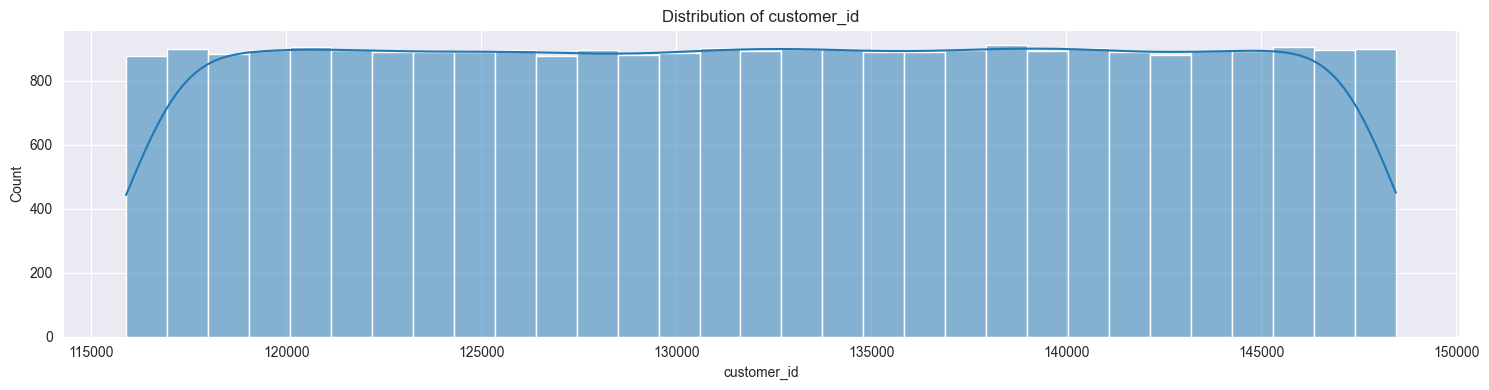

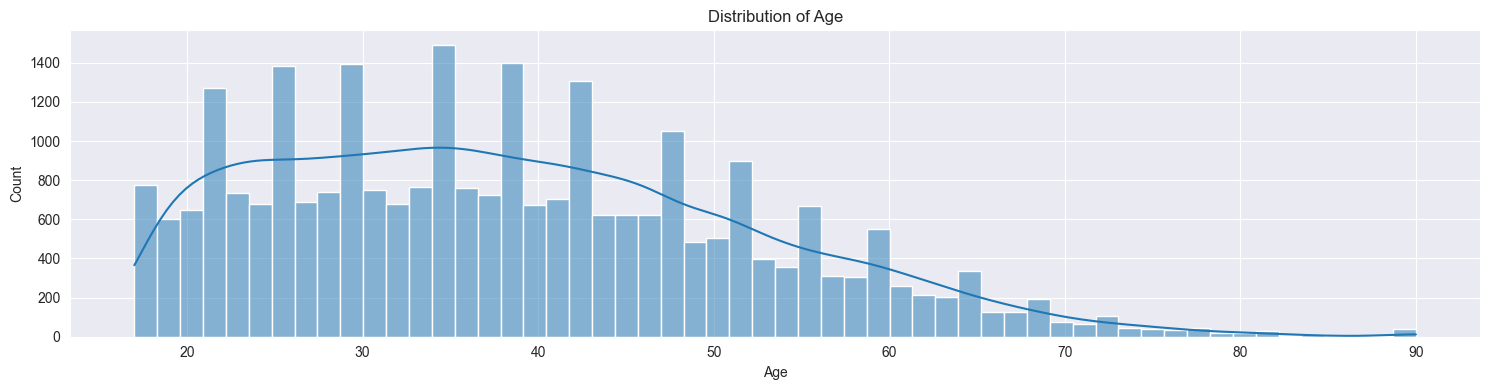

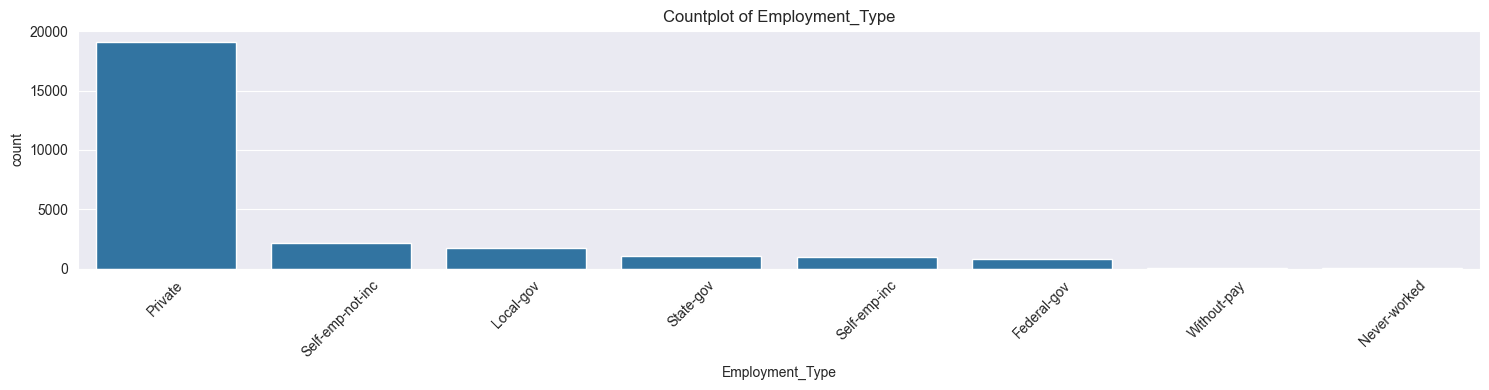

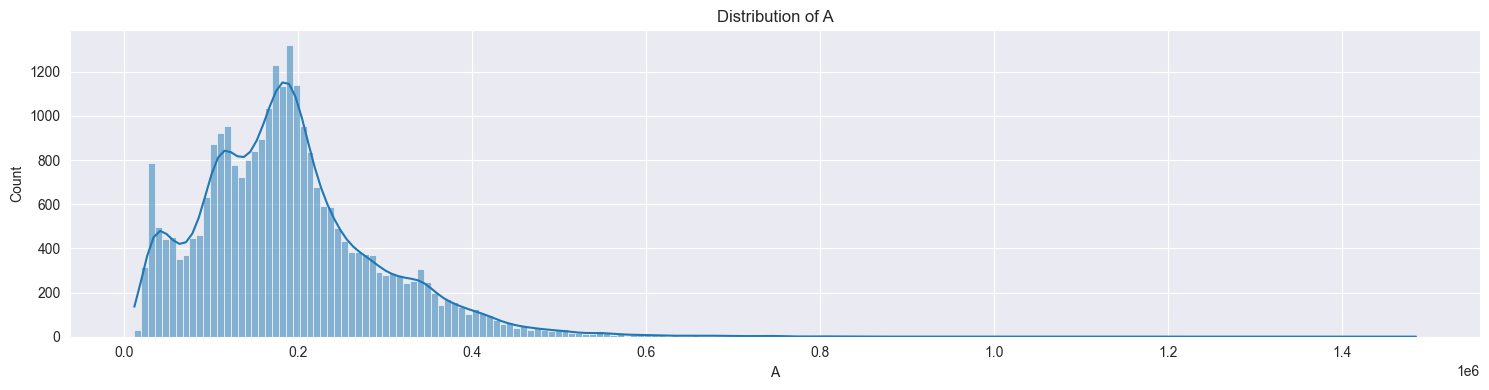

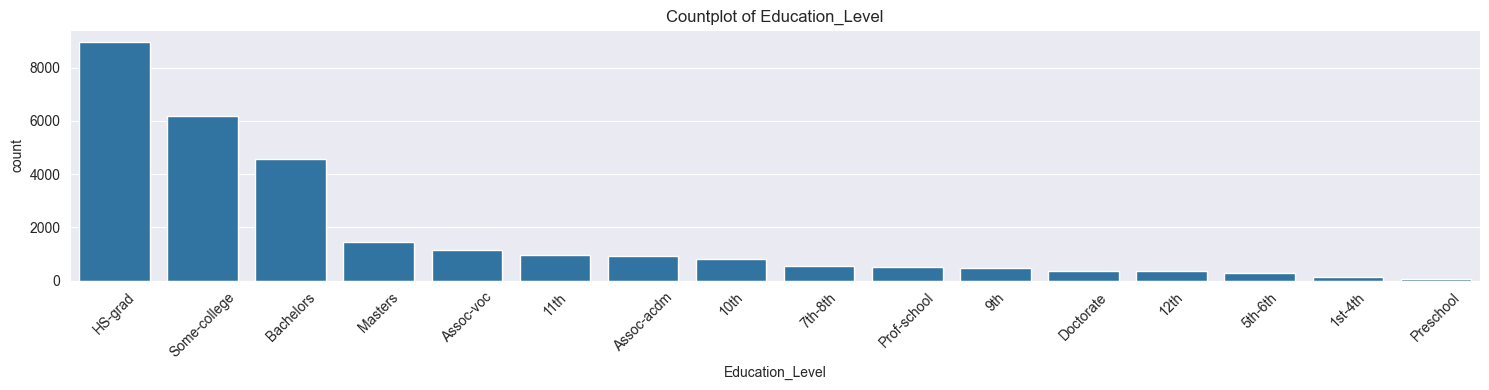

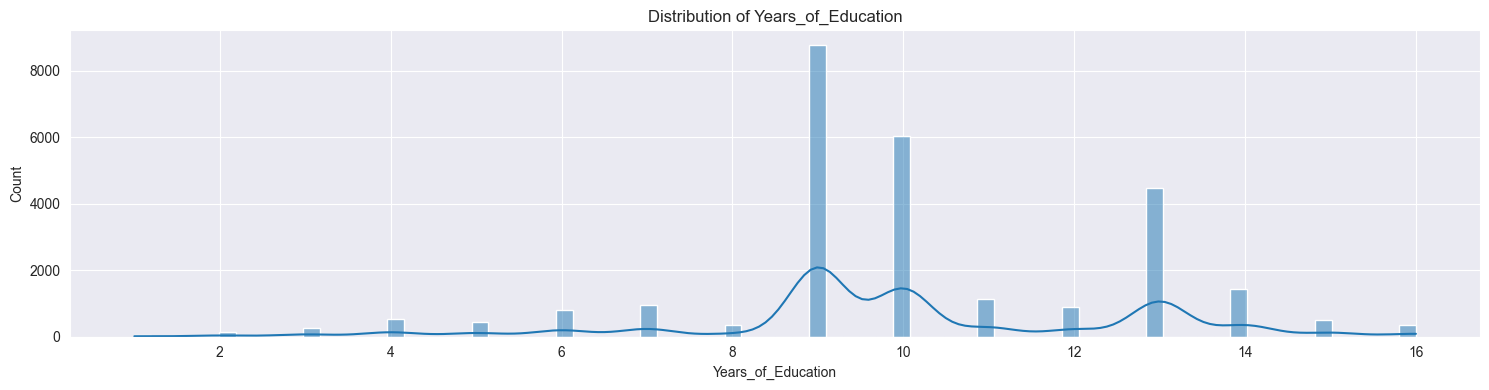

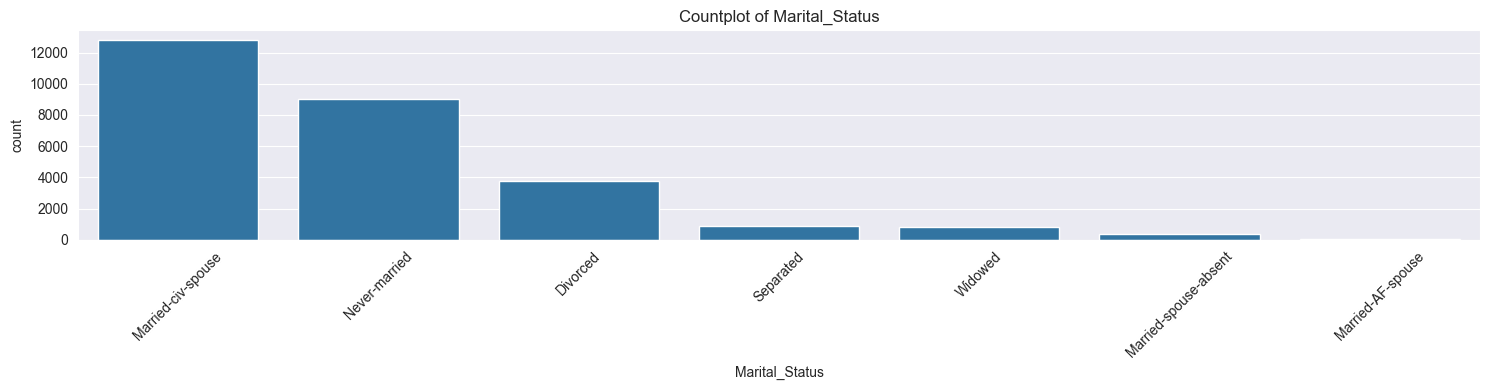

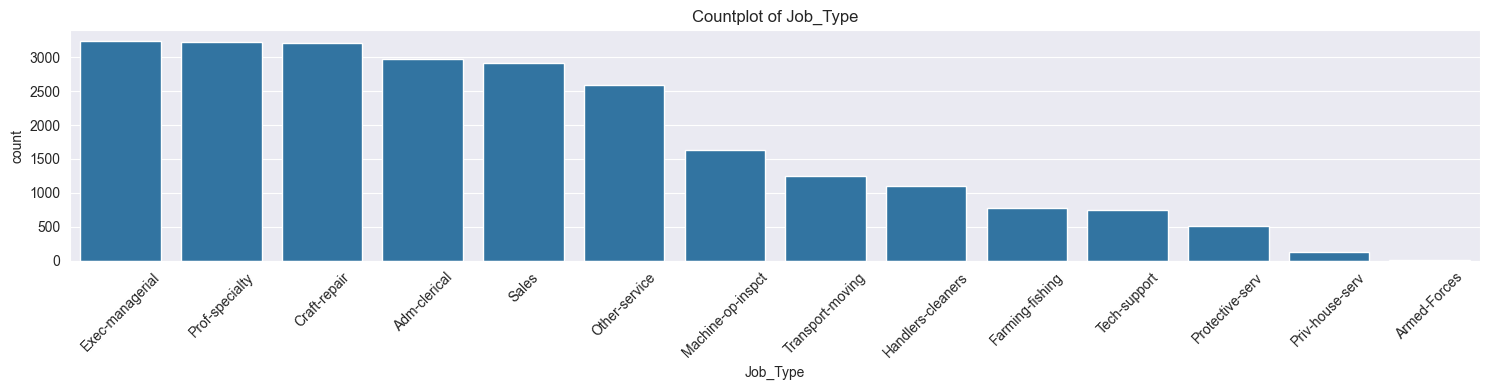

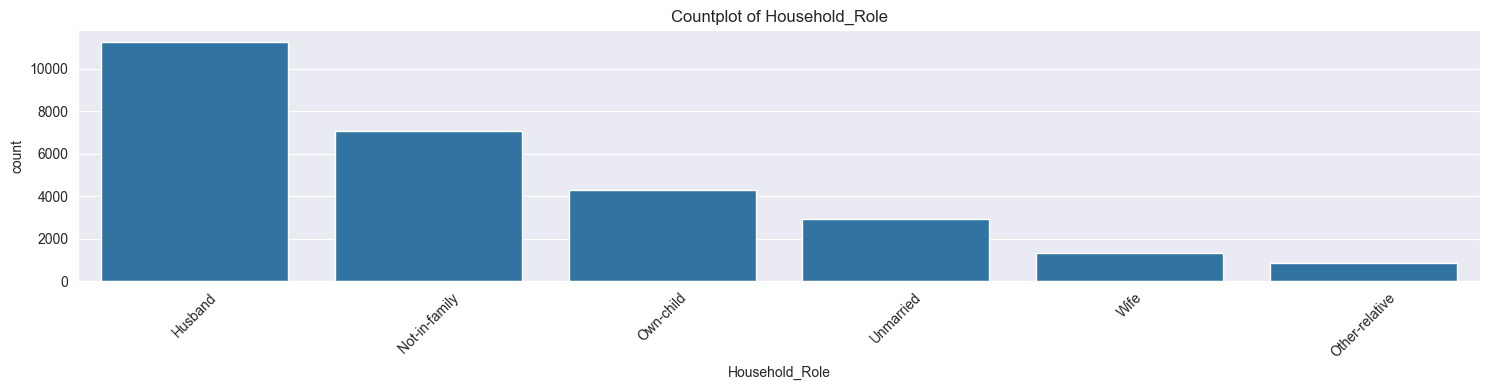

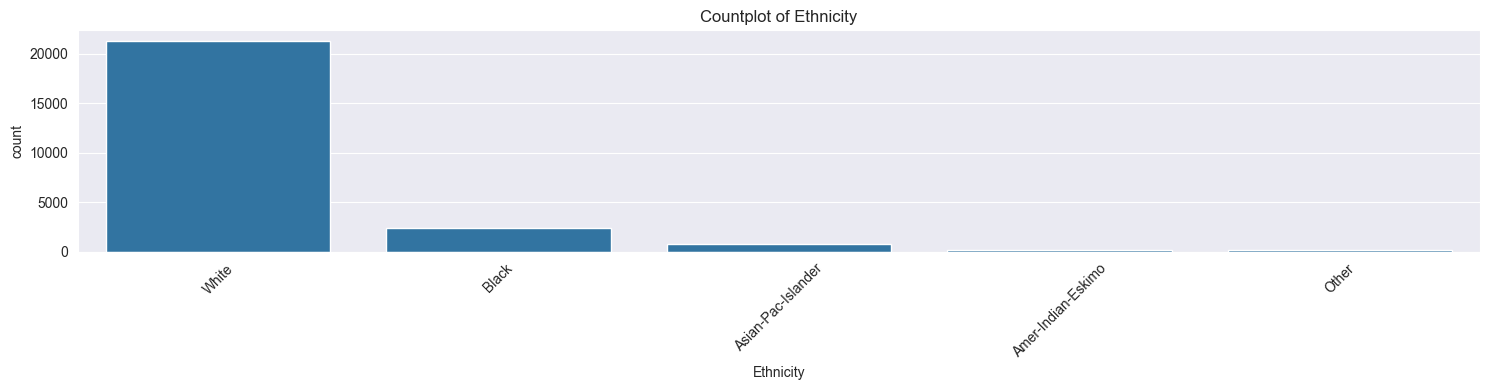

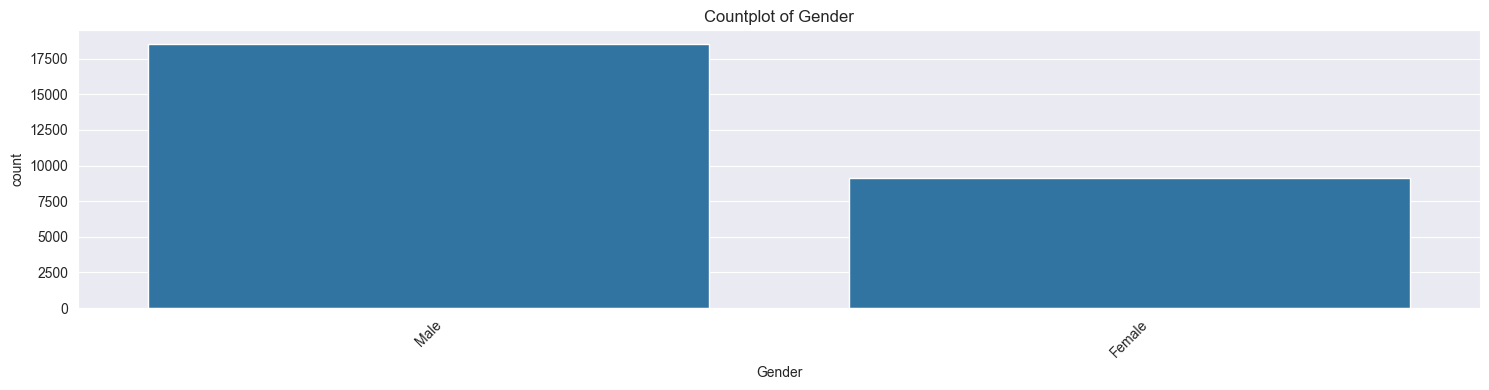

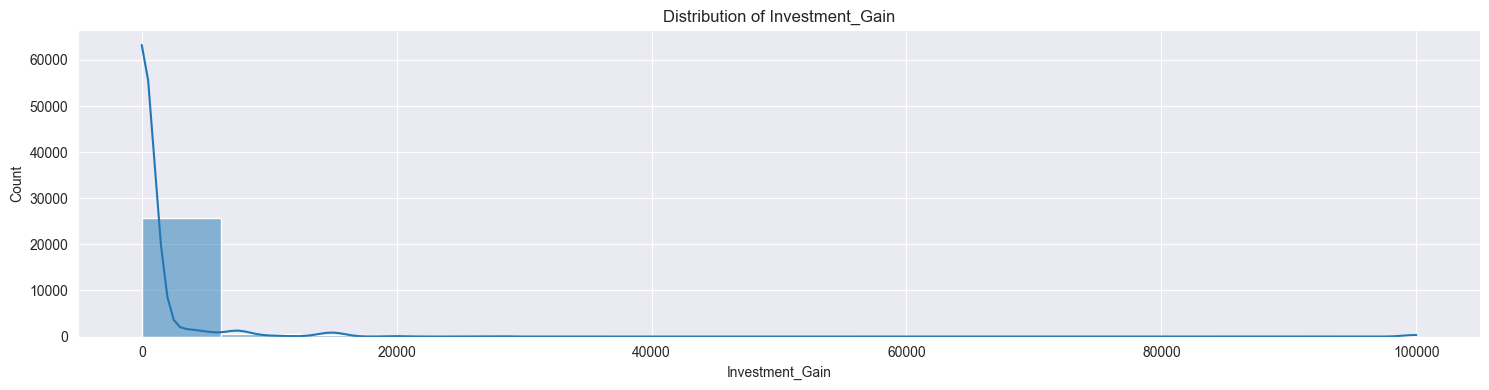

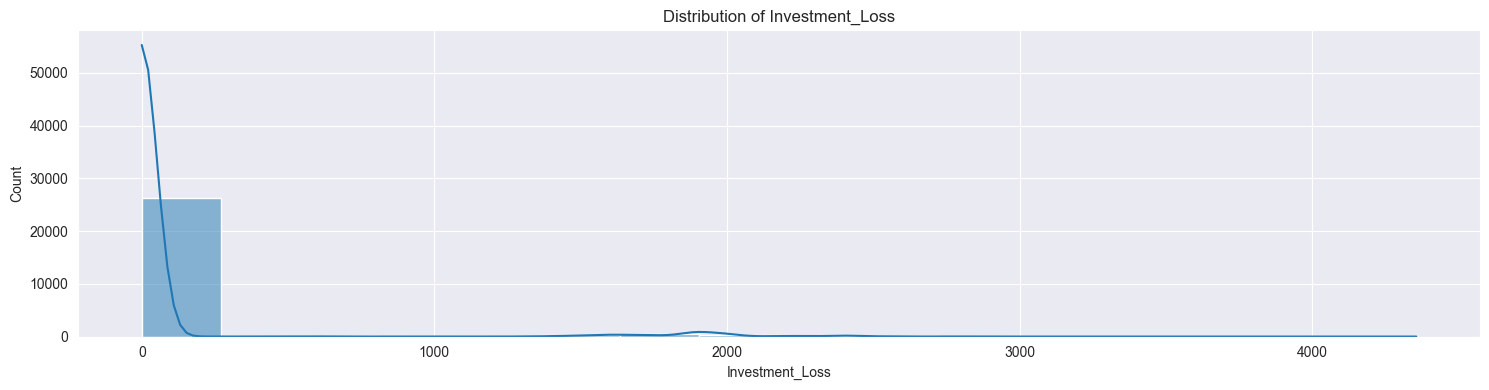

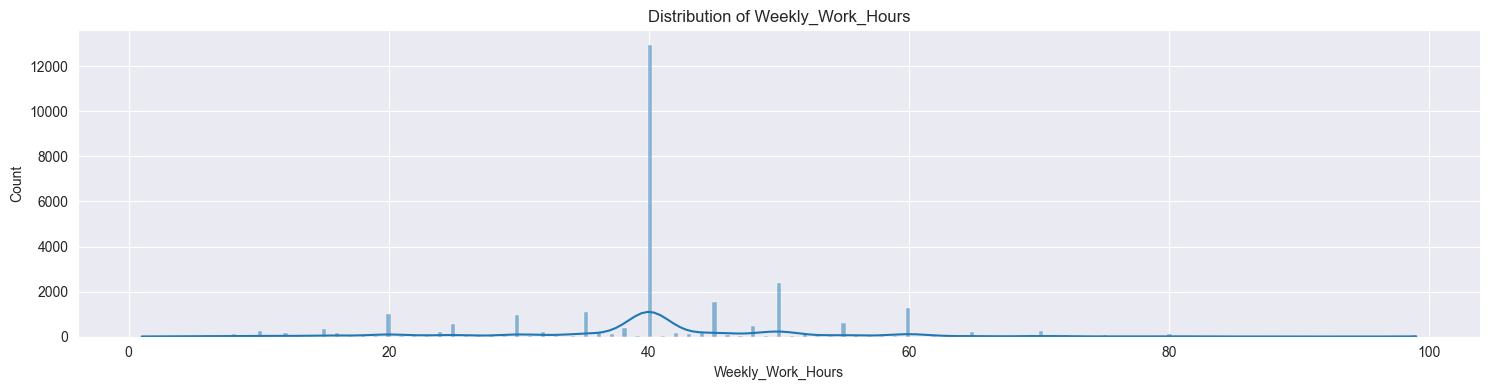

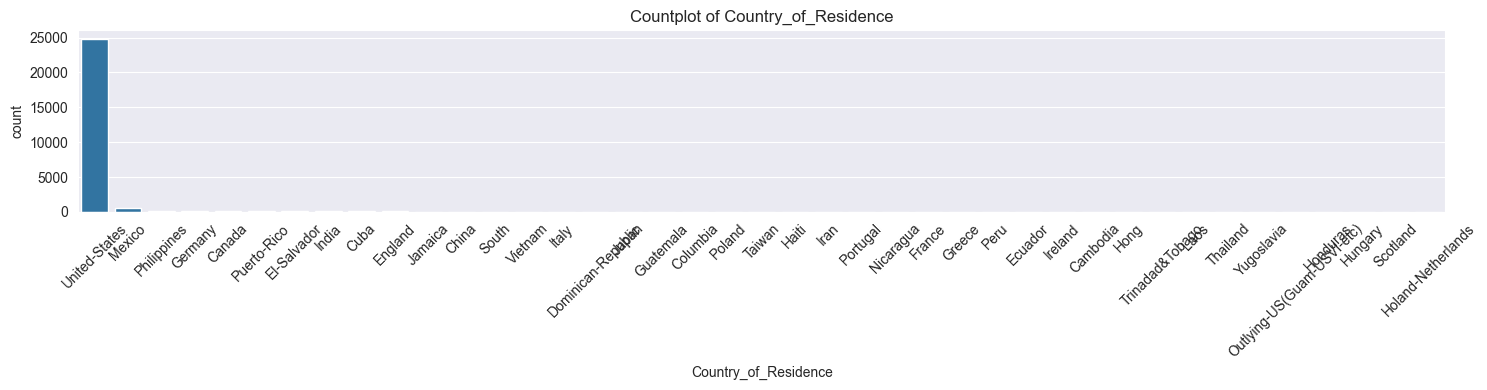

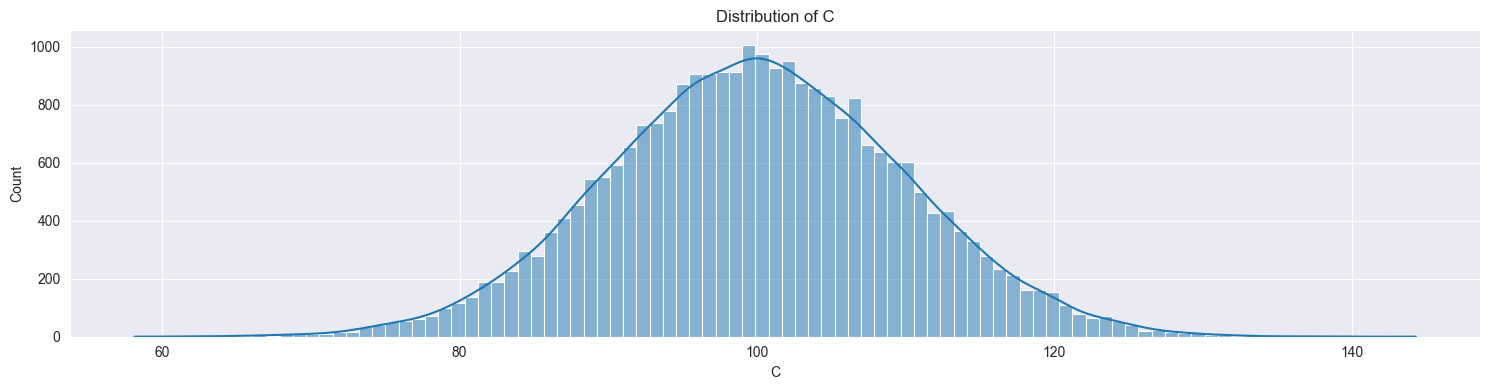

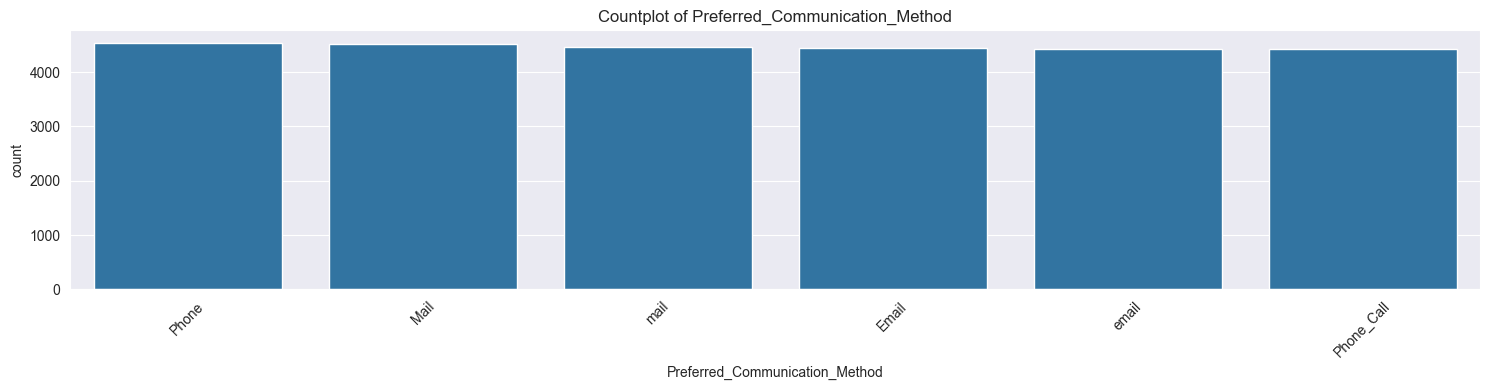

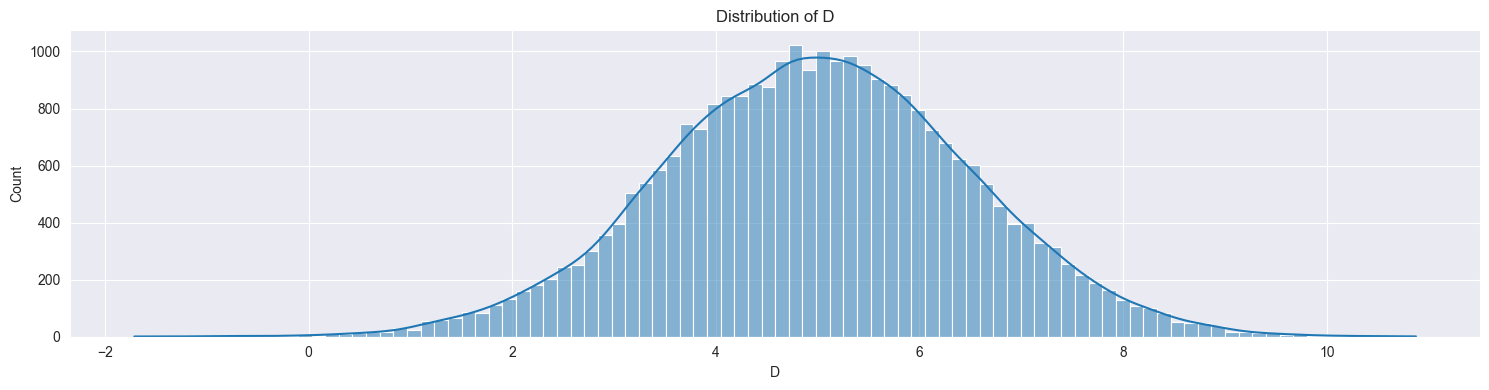

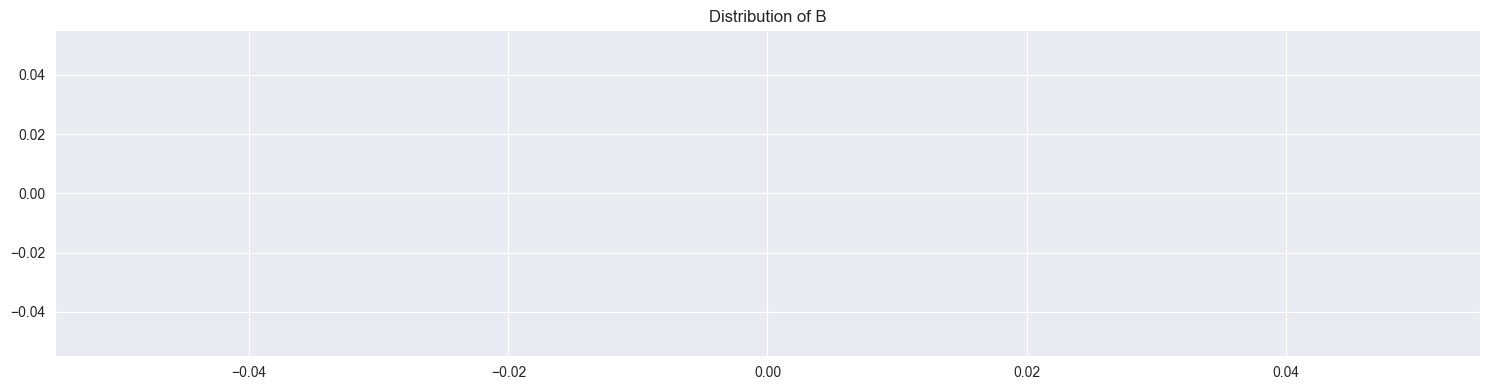

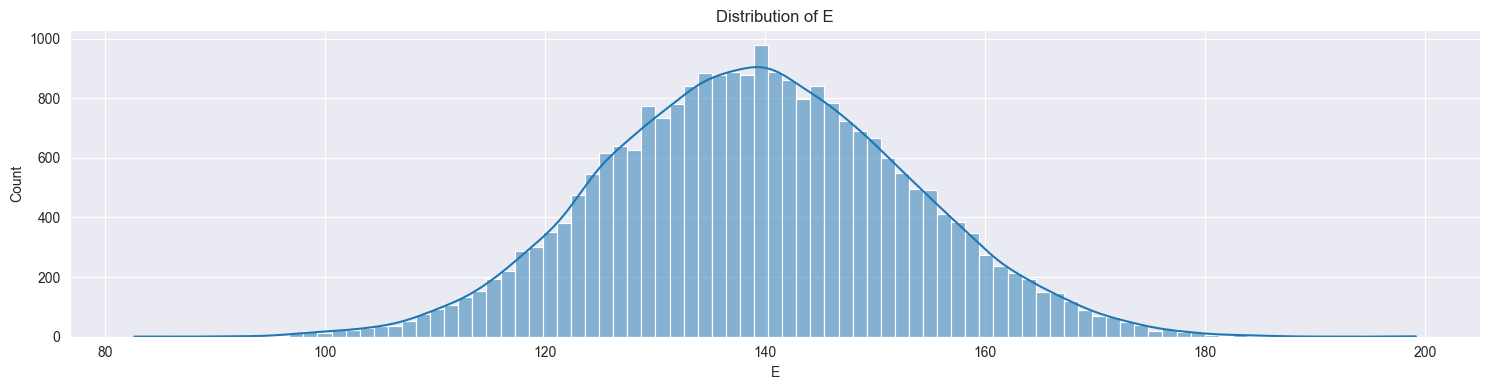

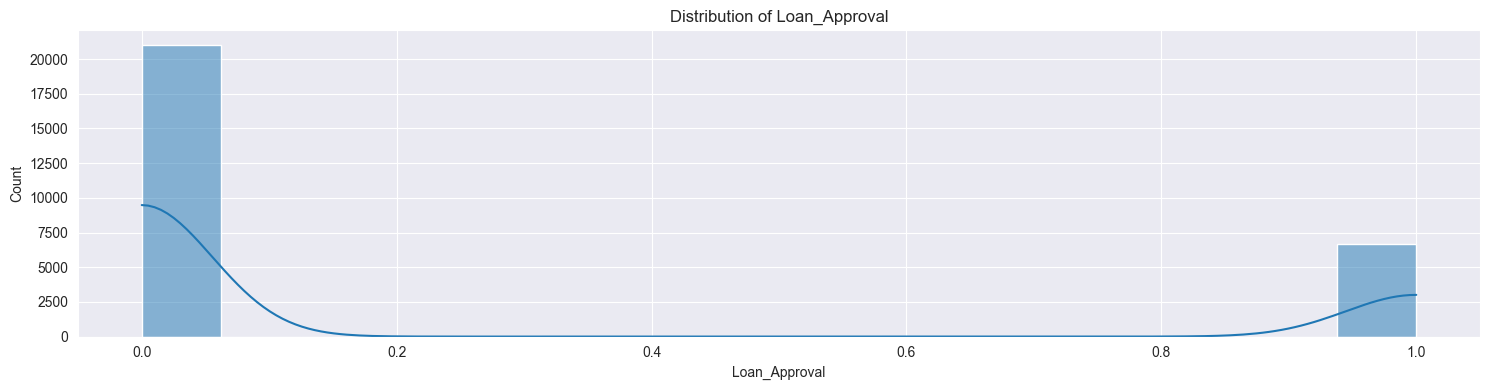

In [73]:
# Histograms and count plots of each explanatory variable

for col in train.columns:
    plt.figure(figsize=(15, 4))
    
    # For numeric variables
    if pd.api.types.is_numeric_dtype(train[col]):
        sns.histplot(train[col].dropna(), kde=True)
        plt.title(f"Distribution of {col}")
    
    # For categorical variables 
    else:
        sns.countplot(x=col, data=train, order=train[col].value_counts().index)
        plt.xticks(rotation=45)
        plt.title(f"Countplot of {col}")
    
    plt.tight_layout()
    plt.show()

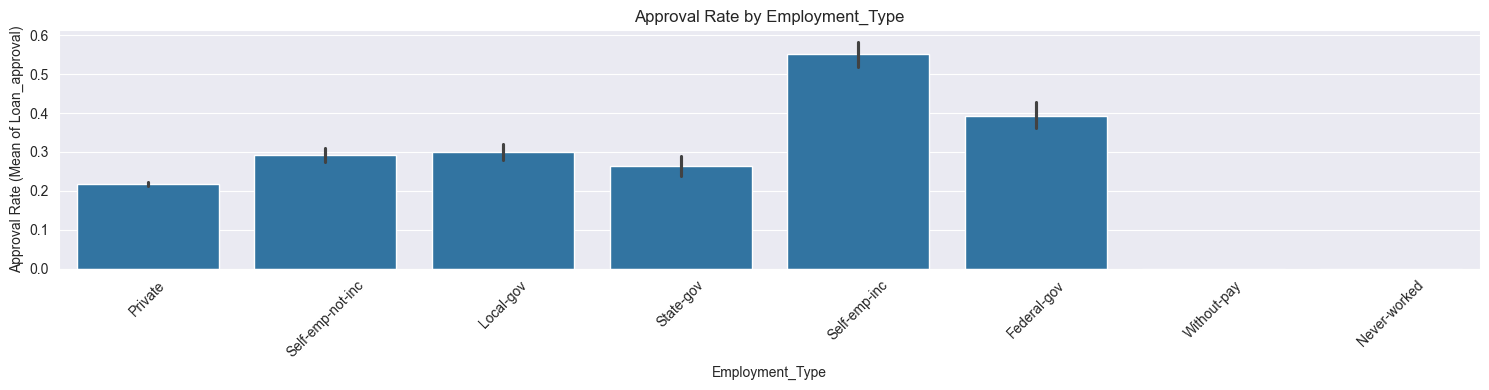

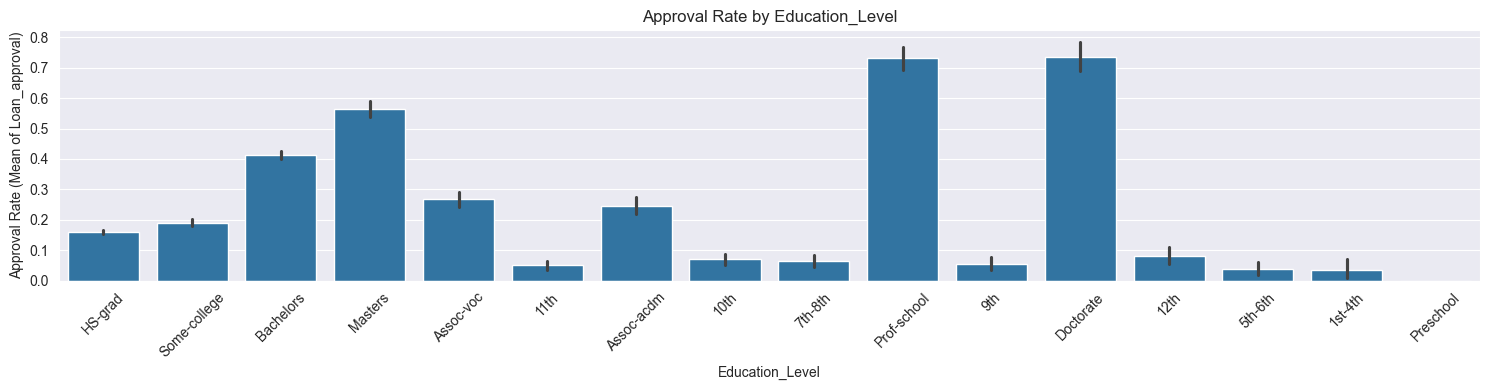

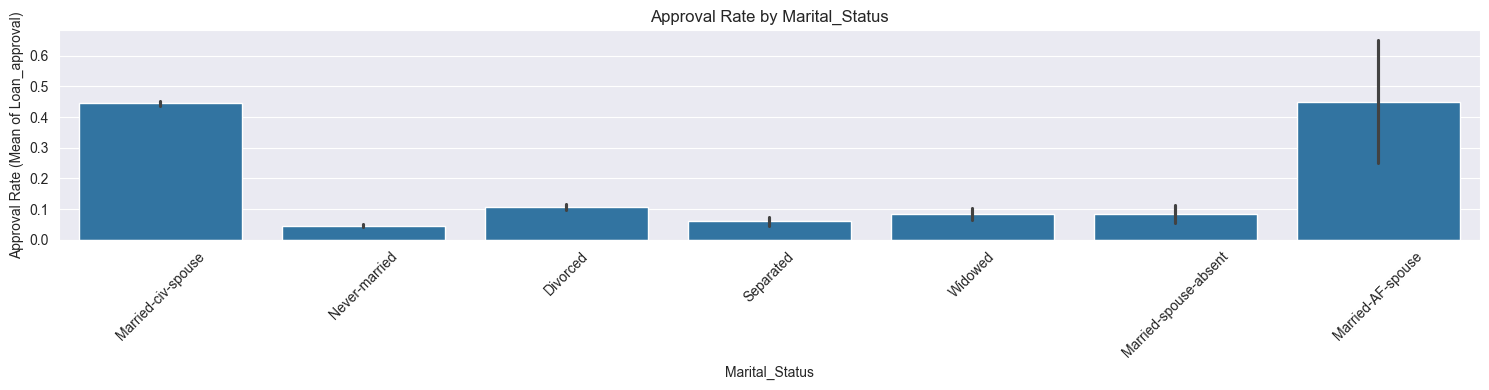

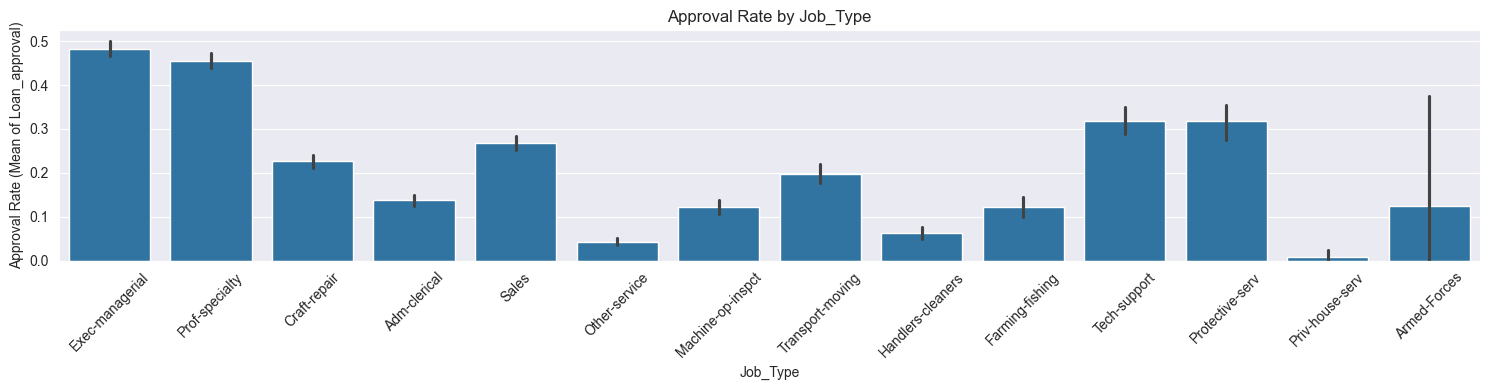

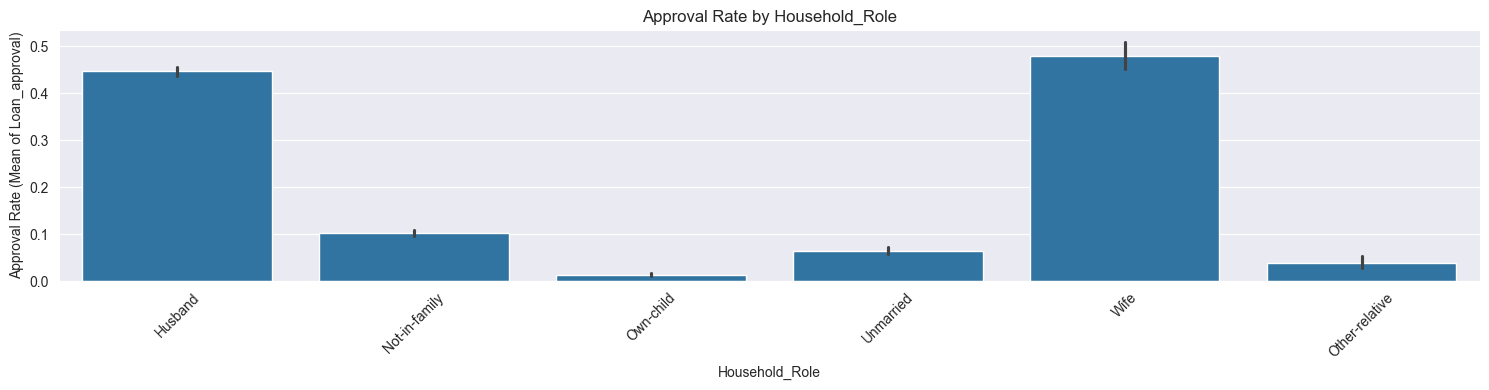

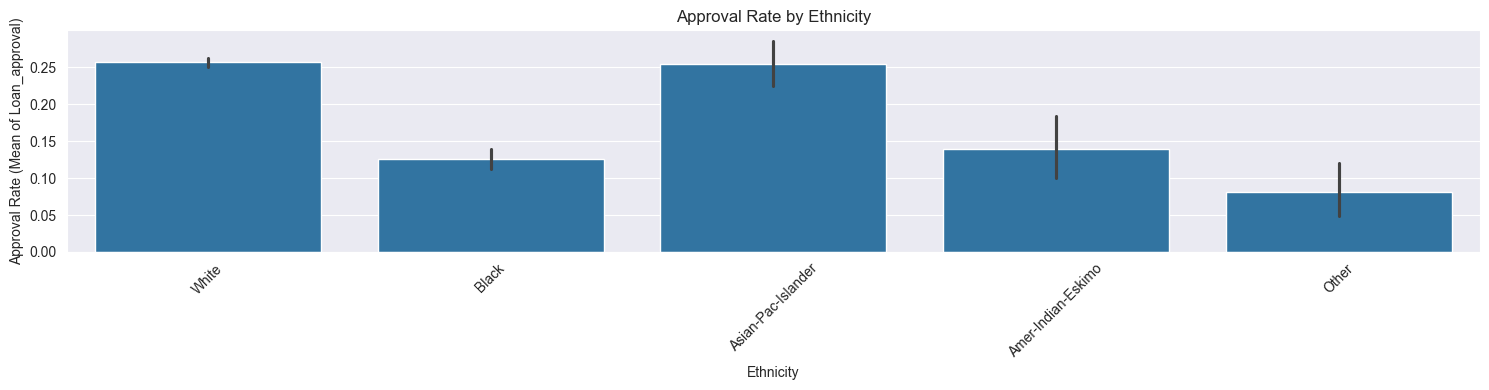

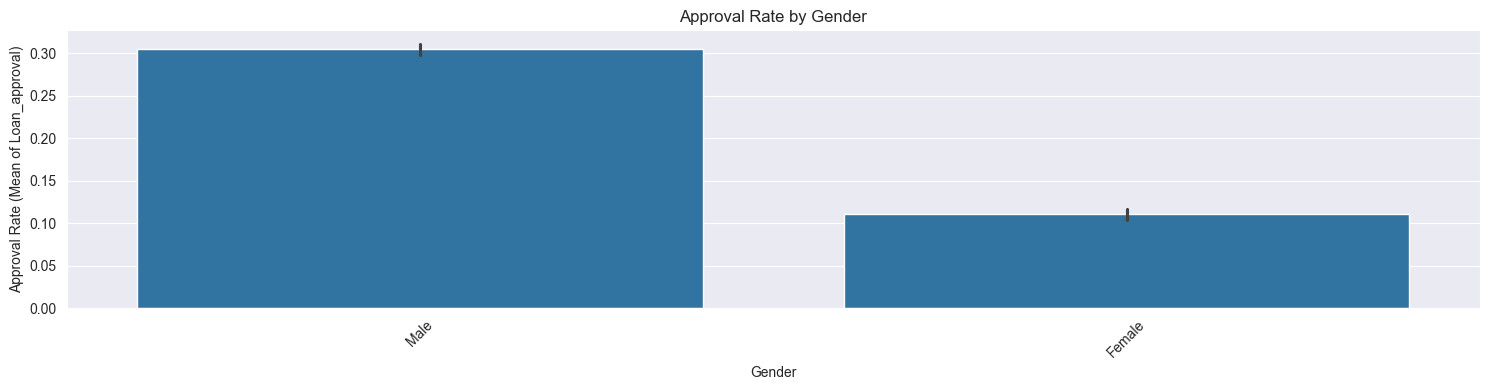

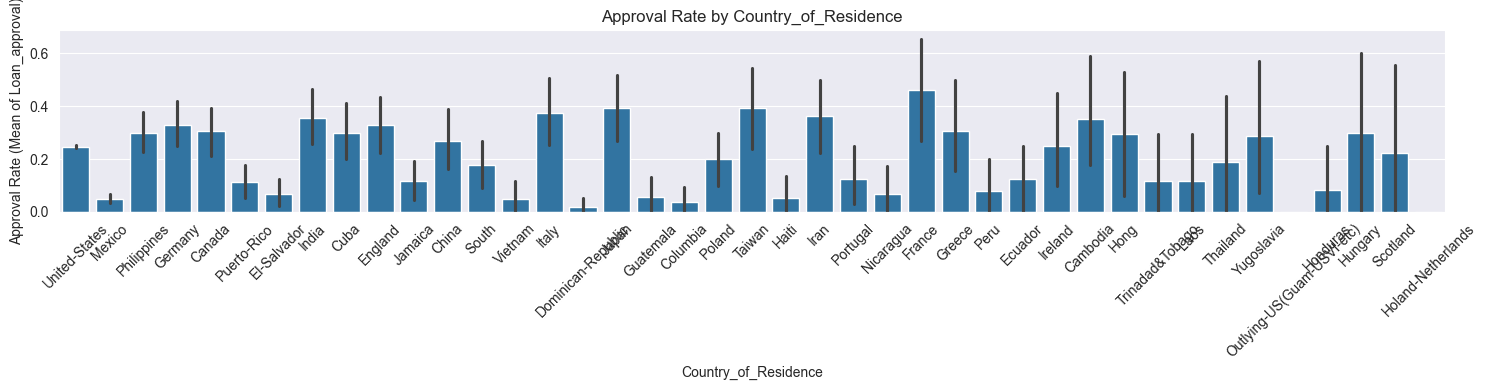

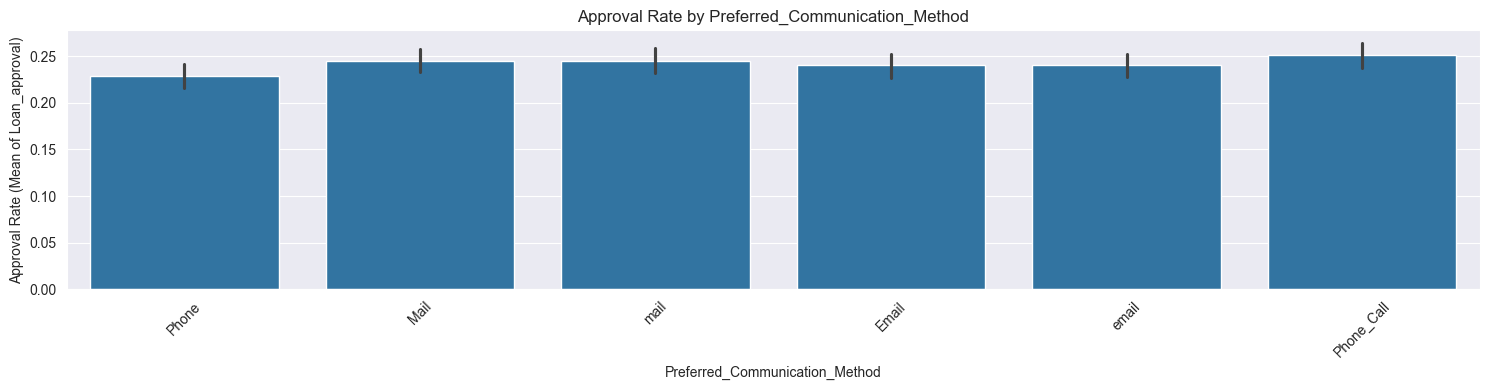

In [74]:
# Bar plots of approval rates for categorical variables

categorical_vars = [
    'Employment_Type', 'Education_Level', 'Marital_Status', 'Job_Type',
    'Household_Role', 'Ethnicity', 'Gender', 'Country_of_Residence',
    'Preferred_Communication_Method'
]

for col in categorical_vars:
    plt.figure(figsize=(15, 4))
    sns.barplot(x=col, y='Loan_Approval', data=train, estimator='mean', order=train[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Approval Rate by {col}')
    plt.ylabel('Approval Rate (Mean of Loan_approval)')
    plt.tight_layout()
    plt.show()

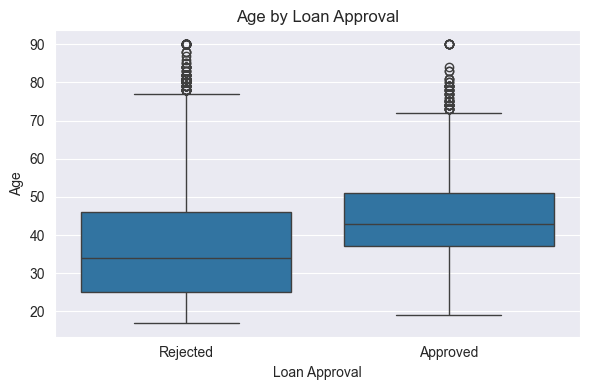

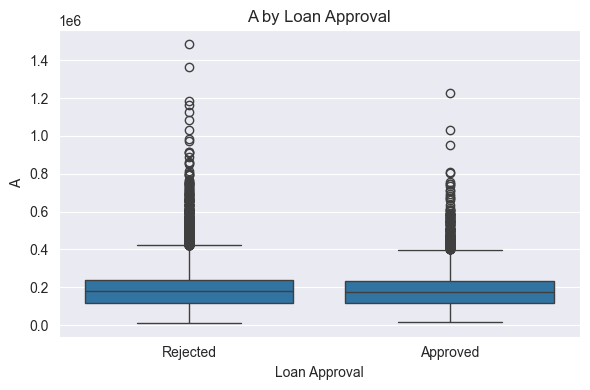

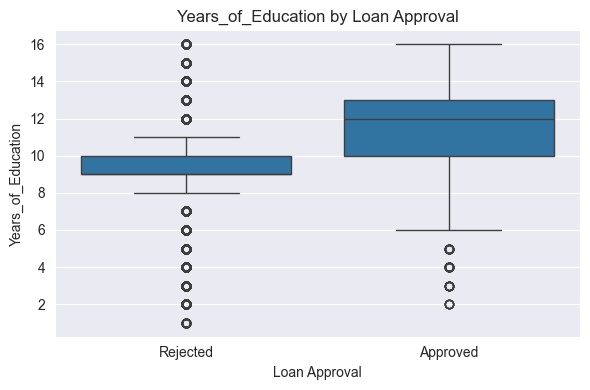

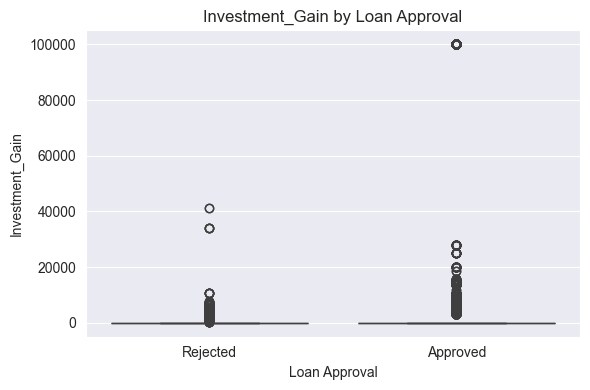

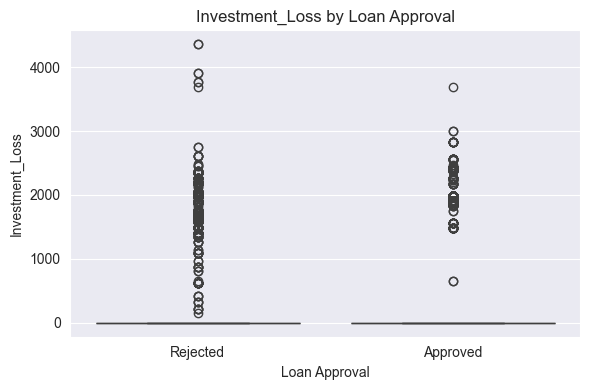

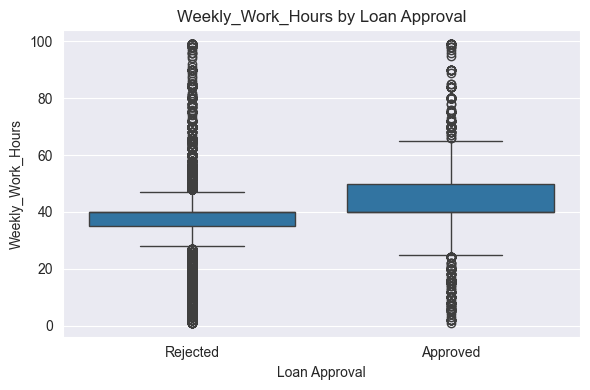

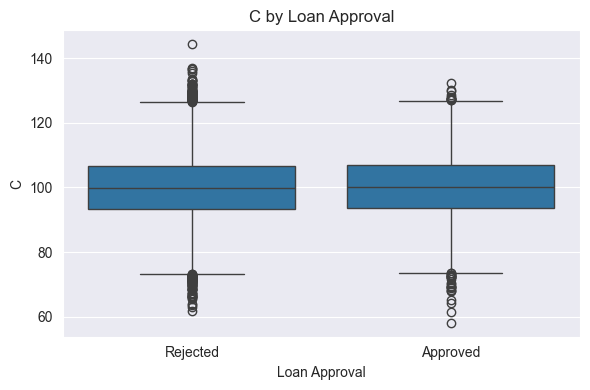

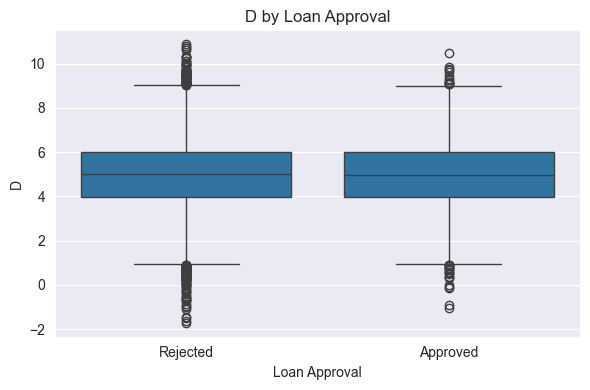

ValueError: List of boxplot statistics and `positions` values must have same the length

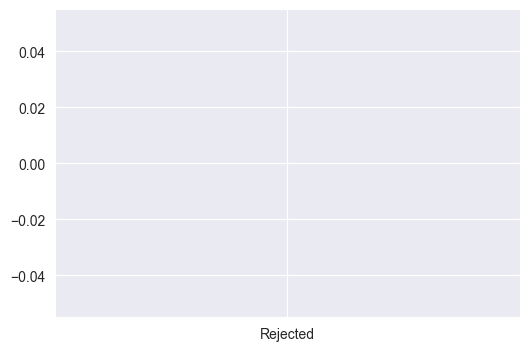

In [75]:
#Box plots of approved vs. rejected for numerical variables
train['Loan_Approval_str'] = train['Loan_Approval'].map({0: 'Rejected', 1: 'Approved'})

# Remove columns that shouldn't be plotted
numeric_cols = [col for col in train.select_dtypes(include='number').columns if col not in ['customer_id', 'Loan_Approval']]

# Create one boxplot per feature vs Loan Approval
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Loan_Approval_str', y=col, data=train)
    plt.title(f'{col} by Loan Approval')
    plt.xlabel('Loan Approval')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

## Part 2 - Data Processing

1. **Normalize** all numeric features (e.g., StandardScaler).  
2. **Handle outliers** (clip or winsorize based on IQR/Z‐score).  
3. **Impute missing values** (median for numeric, “Unknown” for categorical).  
4. **Encode categoricals** (one‐hot, frequency/target encoding, group rare).  
5. **Select or reduce features** (feature importance, PCA, etc.).  
6. **Generate any new features** (e.g., interaction terms, flags).  
7. **Apply identical transforms to the test set**.  


**Key Insights from Feature Distributions**
1. Employment_Type, Country_of_Residence and Ethnicity are highly imbalanced.
To reduce sparsity and improve generalization, we will group the less frequent categories into broader, more meaningful groups.
2. A is right-skewed, so a log transformation may help normalize its distribution.
3. Investment_Gain and Investment_Loss are extremely skewed with large outliers, so a log transformation might help, and merging them into a single Net_Investment feature may provide a clearer signal.
4. Preferred_Communication_Method has inconsistent values due to variations in capitalization and wording (e.g., "Email" vs "email"), so we unified similar values.
5. Based on the approval rate bar plot for Household_Role, we observed clear patterns across the categories.
We grouped them into three broader categories with similar approval behavior to simplify the feature and improve model stability.
6. Column B is completely empty, so we decided to remove it.
7.  We simplified the Country_of_Residence feature by grouping it into three categories: USA, Mexico, and Other. The vast majority of people were from the United States, and the approval rate among other countries wasn't very different.
8.  We simplified the Employment_Type feature by grouping it into four categories: Private, not private and, and non-working.  The vast majority of people were private, and the noticeable difference in the approval rate was between non-private to non-working.



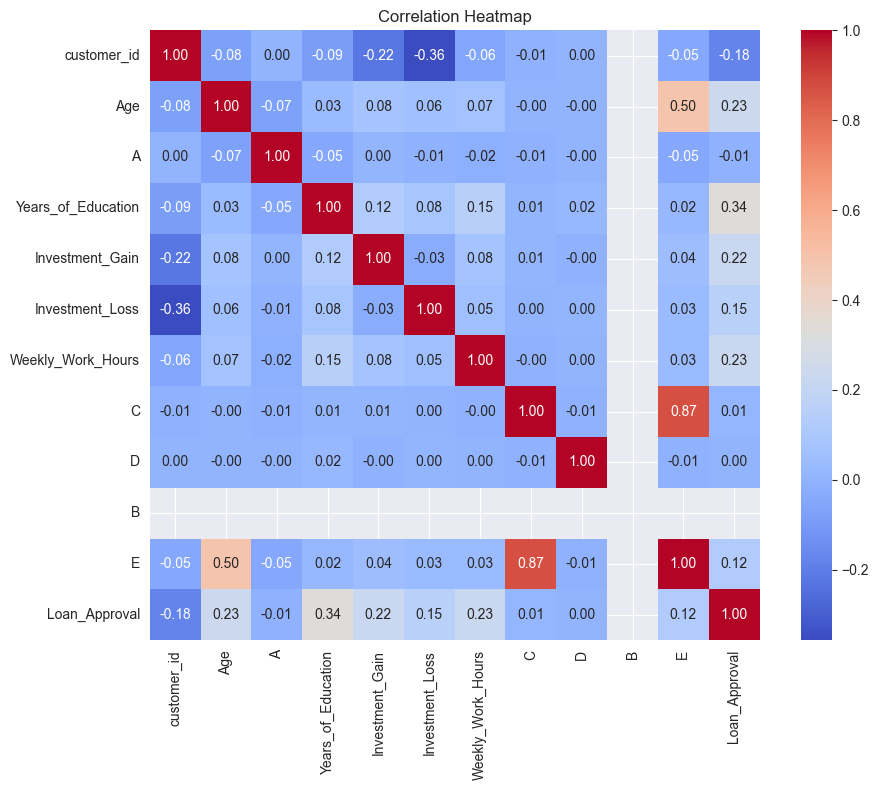

In [76]:
#Creating a heatmap

# Select only numeric columns
numeric_df = train.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [77]:
# Checking which variables are most correlated with Loan_approval (only linear) - this is the Loan_Approval row in the heatmap
numeric_df = train.select_dtypes(include='number')
correlations = numeric_df.corr()['Loan_Approval'].sort_values(ascending=False)
print(correlations)

Loan_Approval         1.000000
Years_of_Education    0.335097
Age                   0.234235
Weekly_Work_Hours     0.226344
Investment_Gain       0.223620
Investment_Loss       0.152074
E                     0.124523
C                     0.010044
D                     0.000003
A                    -0.011856
customer_id          -0.179697
B                          NaN
Name: Loan_Approval, dtype: float64


**Key Insights from the heat map**
C and E are highly correlated (r = 0.87), indicating redundancy.
Neither has a strong linear correlation with the target, but E shows a slightly stronger signal (r = 0.125). Even though E has more missing values (as we will see later on), it’s still more useful, so we’ll keep E and drop C. 

We checked for overlap between Employment_Type and Job_Type using a cross-tabulation heatmap.
The results show no strong or consistent relationship between the two — most employment types are associated with a wide variety of job types.
Therefore, we concluded that the two features capture distinct information and chose to keep both.

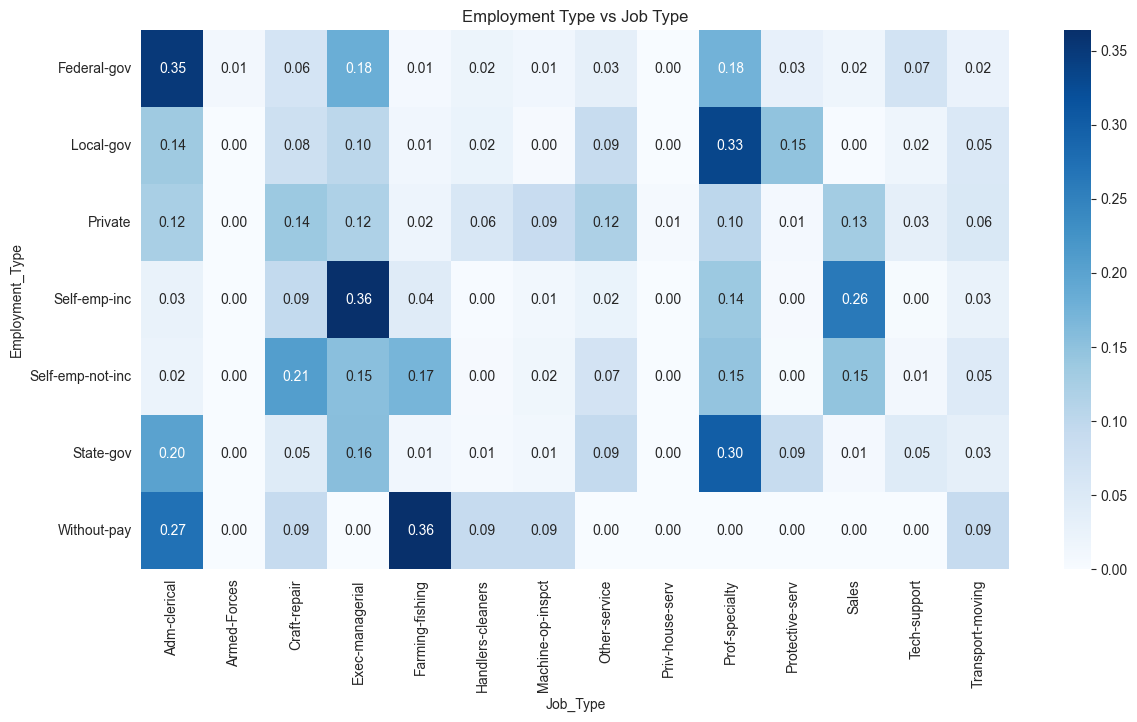

In [78]:
crosstab = pd.crosstab(train['Employment_Type'], train['Job_Type'], normalize='index')
plt.figure(figsize=(14, 7))
sns.heatmap(crosstab, cmap="Blues", annot=True, fmt=".2f")
plt.title("Employment Type vs Job Type")
plt.show()

## 3. Data Preprocessing
_Handle missing values, encode categorical features, normalize, etc._



_Changes based on the key insights:_

In [79]:
# 1. Removing columns B and C
train = train.drop(['B', 'C'], axis=1)
test = test.drop(['B', 'C'], axis=1)
n_columns -= 2

**Outlier Removal:**


Based on our initial EDA (where we plotted boxplots and histograms in Part 1), we selected seven features—net_investment_log, Weekly_Work_Hours, Years_of_Education, Age, A, D, and E—for outlier removal. First, we computed and displayed the five-number summary (Min, Q1, Median, Q3, Max) for each to see which values lay far outside the interquartile range. For net_investment_log, we then calculated its mean and standard deviation and removed any rows whose values fell beyond ± 4 σ; this eliminates only about 800 observations (≈ 3 % of the data), preserving most valid high-net-worth cases. For the anonymous columns A and E, we used the IQR rule and deleted any rows outside [Q1 − 1.5·IQR, Q3 + 1.5·IQR]. Feature D which had a narrow IQR was trimmed for any value outside [1, 9] (its 1.5·IQR boundaries) was removed. Since Age and Years_of_Education fell entirely within reasonable IQR bounds, we left them intact. Finally, because some applicants truly work long hours, we decided to remove (rather than cap) only those Weekly_Work_Hours values above the 99th percentile, ensuring that genuine 60–80-hour workweeks remain in the data while the most extreme outliers are excluded.

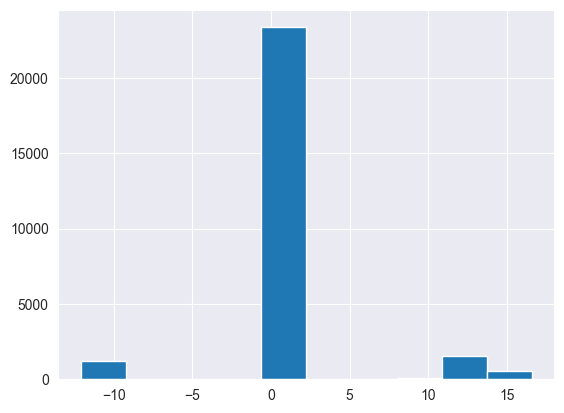

Text(0.5, 1.0, 'Distribution of net_investment_log')

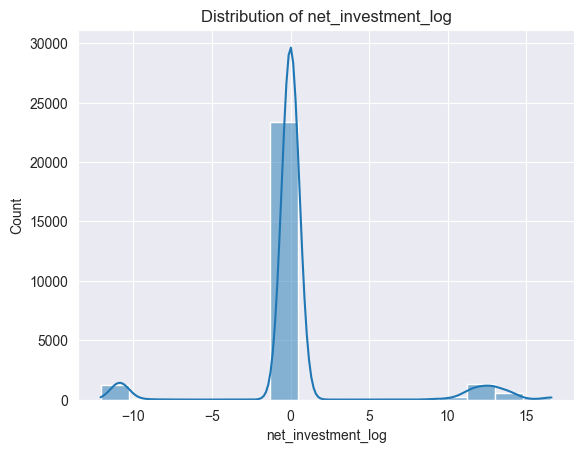

In [80]:
train['log_gain'] = np.log2(train['Investment_Gain'] + 1)
train['log_loss'] = np.log2(train['Investment_Loss'] + 1)
train['net_investment_log'] = train['log_gain'] - train['log_loss']

plt.hist(train['net_investment_log'])
plt.show()

sns.histplot(train['net_investment_log'].dropna(), kde=True)
plt.title(f"Distribution of net_investment_log")

In [81]:
# List of numeric features we care about
features = [
    "net_investment_log",
    "Weekly_Work_Hours",
    "Years_of_Education",
    "Age",
    "A",
    "D",
    "E",
    "Investment_Gain",
    "Investment_Loss"
]

# Compute the five‐number summary (min, Q1, median, Q3, max) for each feature
summary = train[features].quantile([0.00, 0.25, 0.50, 0.75, 1.00]).T
summary.columns = ["Min", "Q1", "Median", "Q3", "Max"]
summary_int = summary.round(0).astype(int)

print(summary_int)

                      Min      Q1  Median      Q3      Max
net_investment_log    -12       0       0       0       17
Weekly_Work_Hours       1      40      40      45       99
Years_of_Education      1       9      10      12       16
Age                    17      28      37      48       90
A                   12285  117765  178587  237634  1484705
D                      -2       4       5       6       11
E                      83     130     139     148      199
Investment_Gain         0       0       0       0    99999
Investment_Loss         0       0       0       0     4356


In [82]:
'''# Remove outliers from 'net_investment_log' using 3 standard deviations
mean_log = train["net_investment_log"].mean()
std_log  = train["net_investment_log"].std()
lower  = mean_log - 4 * std_log
upper  = mean_log + 4 * std_log
train = train[(train["net_investment_log"] >= lower) & (train["net_investment_log"] <= upper)]
'''
'''
# Remove outliers from 'A' using IQR
Q1_A, Q3_A = train["A"].quantile([0.25, 0.75])
IQR_A      = Q3_A - Q1_A
lower_A    = Q1_A - 1.5 * IQR_A
upper_A    = Q3_A + 1.5 * IQR_A
train = train[(train["A"] >= lower_A) & (train["A"] <= upper_A)]

# Keep only values between 1 and 9 for column 'D'
train = train[(train["D"] >= 1) & (train["D"] <= 9)]
'''
# Remove outliers from 'E' using IQR
Q1_E, Q3_E = train["E"].quantile([0.25, 0.75])
IQR_E      = Q3_E - Q1_E
lower_E    = Q1_E - 1.5 * IQR_E
upper_E    = Q3_E + 1.5 * IQR_E
train = train[(train["E"] >= lower_E) & (train["E"] <= upper_E)]


In [85]:
# Compute 99th percentile
p99 = train["Weekly_Work_Hours"].quantile(0.99)

# Remove rows where Weekly_Work_Hours > 99th percentile
train = train[train["Weekly_Work_Hours"] <= p99]

# print new max for verification
print("New max after filtering:", train["Weekly_Work_Hours"].max())
print("99th percentile used as threshold:", p99)

New max after filtering: 66
99th percentile used as threshold: 66.0


In [86]:
train.shape

(23637, 23)

This cell defines helper functions to collapse rarely seen categories into broader groups, reducing cardinality for certain columns.
These functions prepare us to reduce the number of dummy columns later on when we one-hot encode.

In [87]:
# ------------ Grouping functions ------------

# Grouping Preferred_Communication_Method
def group_pref_com(pref):
    if pref == "Mail" or pref == "mail":
        return "Mail"
    if pref == "Email" or pref == "email":
        return "EMail"
    if pref == "Phone" or pref == "phone" or pref == "phone call":
        return "Phone"
    else:
        return "Other"

# Grouping Country_of_Residence
def group_country(country):
    if country == "United-States":
        return "USA"
    elif country == "Mexico":
        return "Mexico"
    else:
        return "Other"
    
# Grouping Education_Level
def group_education(edu):
    pre_school = ['Preschool']
    school = ['1st-4th', '5th-6th', '9th', '10th', '11th', '12th', '7th-8th']
    post_hs = ['HS-grad', 'Some-college']
    assoc = ['Assoc-voc', 'Assoc-acdm']
    higher = ['Masters', 'Bachelors']
    postgraduate = ['Doctorate', 'Prof-school']
    
    if edu in pre_school:
        return 'pre_school'
    elif edu in school:
        return 'school'
    elif edu in post_hs:
        return 'post_hs'
    elif edu in assoc:
        return 'assoc'
    elif edu in higher:
        return 'higher'
    elif edu in postgraduate:
        return 'postgraduate'
    else:
        return 'Other'
    
# Grouping Household_role
def group_household_role(role):
    if role in ['Husband', 'Wife']:
        return 'Spouse'
    else:
        return 'Other'

# Grouping Employment_Type
def group_employment(emp):
    if emp == 'Private':
        return 'Private'
    elif emp in ['Self-emp-not-inc', 'Self-emp-inc', 'Local-gov', 'State-gov', 'Federal-gov']:
        return 'Not-Private'
    elif emp in ['Without-pay', 'Never-worked']:
        return 'Non-working'
    else:
        return 'Other'
    
# Grouping Ethnicity:
def group_ethnicity(eth):
    if eth == 'White':
        return 'White'
    elif eth == 'Black':
        return 'Black'
    else:
        return 'Other'
    
# 1. Mapping dictionary for Years_of_Education
edu_to_years = {
    'Preschool'    : 0,
    '1st-4th'      : (1 + 2 + 3 + 4) / 4,
    '5th-6th'      : 5.5,
    '7th-8th'      : 7.5,
    '9th'          : 9,
    '10th'         : 10,
    '11th'         : 11,
    '12th'         : 12,
    'HS-grad'      : 12,
    'Some-college' : (12 + 13 + 14 + 15) / 4,
    'Assoc-voc'    : 14,
    'Assoc-acdm'   : 14,
    'Bachelors'    : 16,
    'Masters'      : 18,
    'Prof-school'  : 19,
    'Doctorate'    : 20
}


def group_edu_years(X):
    # Ensure X is treated as a 2D array
    arr = X.to_numpy()
    
    if arr.ndim != 2 or arr.shape[1] != 2:
        raise ValueError("group_edu_years expects exactly 2 columns: [Years_of_Education, Education_Level]")
    
    # Now arr[:, 0] and arr[:, 1] work as intended
    raw_years   = pd.Series(arr[:, 0])
    raw_levels  = pd.Series(arr[:, 1])
    
    # Map Education_Level → numeric years
    mapped_years = raw_levels.map(edu_to_years)
    
    # Fill NaN in raw_years with mapped_years
    filled = raw_years.fillna(mapped_years)
    
    # Return a single-column DataFrame
    return filled.to_frame(name="Years_of_Education")


In this cell, we apply each grouping function to the raw columns and create new “_grouped” columns in both train and test.

In [88]:
from sklearn.preprocessing import FunctionTransformer
import pandas as pd

# 1. Single-column groupers: convert X (which may be a 1-col DataFrame or 2D array shape (n,1))
#    into a flat 1D array via X.to_numpy().ravel(), then map the scalar function.

pref_com_group = FunctionTransformer(
    func=lambda X: pd.Series(
        X.to_numpy().ravel()
    ).map(group_pref_com).to_frame("Preferred_Communication_Method"),
    validate=False
)

country_group = FunctionTransformer(
    func=lambda X: pd.Series(
        X.to_numpy().ravel()
    ).map(group_country).to_frame("Country_of_Residence"),
    validate=False
)

edu_level_group = FunctionTransformer(
    func=lambda X: pd.Series(
        X.to_numpy().ravel()
    ).map(group_education).to_frame("Education_Level_Mapped"),
    validate=False
)

house_hold_group = FunctionTransformer(
    func=lambda X: pd.Series(
        X.to_numpy().ravel()
    ).map(group_household_role).to_frame("Household_Role"),
    validate=False
)

emp_type_group = FunctionTransformer(
    func=lambda X: pd.Series(
        X.to_numpy().ravel()
    ).map(group_employment).to_frame("Employment_Type"),
    validate=False
)

ethnicity_group = FunctionTransformer(
    func=lambda X: pd.Series(
        X.to_numpy().ravel()
    ).map(group_ethnicity).to_frame("Ethnicity"),
    validate=False
)


# 2. Two-column grouper: 
#    X will be shape (n_samples, 2), where column 0 = Years_of_Education,
#    column 1 = Education_Level. We need to call group_edu_years on each row.

edu_years_group = FunctionTransformer(
    func=lambda X: group_edu_years(X),
    validate=False
)



In [92]:
# ------------ pipelines ------------

# Preferred_Communication_Method pipeline
pref_pipeline = Pipeline([
    ('group', pref_com_group),  
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Country_of_Residence pipeline
country_pipeline = Pipeline([
    ('group', country_group),
    ('impute', SimpleImputer(strategy='most_frequent')),  # or 'constant' if you prefer
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Education_Level pipeline
edu_pipeline = Pipeline([
    ('group', edu_level_group),
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Employment_Type pipeline
employment_pipeline = Pipeline([
    ('group', emp_type_group),
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Ethnicity pipeline
ethnicity_pipeline = Pipeline([
    ('group', ethnicity_group),
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Household pipeline
Household_pipeline = Pipeline([
    ('group', house_hold_group),
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Years of education pipeline
edu_years_pipeline = Pipeline([
    ('fill_years', edu_years_group),
    ('impute_years', SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()), 
])


# columns without special adjustments:
categorical_col = ['Gender', 'Marital_Status', 'Job_Type', 'Employment_Type']
numerical_col = ['E']
skw_numerical_col = ['Age', 'Investment_Gain', 'Investment_Loss']

# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for numerical features (mean imputation)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()), 

])

# Pipeline for numerical features (median imputation) - for skewed columns
skw_numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()), 
])


# Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('pref_communication',       pref_pipeline,         ['Preferred_Communication_Method']),
    ('country',    country_pipeline,      ['Country_of_Residence']),
    ('edu_level',  edu_pipeline,          ['Education_Level']),
    ('edu_years',  edu_years_pipeline,    ['Years_of_Education', 'Education_Level']),
    ('employment_type', employment_pipeline,   ['Employment_Type']),
    ('ethnicity',  ethnicity_pipeline,    ['Ethnicity']),
    ('household_role',  Household_pipeline,    ['Household_Role']),
    ('cat',  cat_pipeline,          ['Gender', 'Marital_Status', 'Job_Type', 'Employment_Type']), # Other categorical columns
    ('num',  num_pipeline,          ['E']),                                                       # Simple numeric column
    ('skw_num',    skw_numerical_pipeline,['Age', 'Investment_Gain', 'Investment_Loss'])                # Skewed numeric columns    
    ],
    remainder="passthrough"
    # All remaining columns that were not specified in transformer. These columns don't need any transformation. This subset of columns is concatenated with the output of the transformers.
)



In [93]:
df_raw = train.copy()

# 1. Fit your preprocessor on the raw data (if you haven't already)
#    - If you already ran `preprocessor.fit(...)` earlier, you can skip
#      the fit step and go straight to transform().
preprocessor.fit(df_raw)

# 2. Transform the data to get a NumPy array of size (n_samples, n_total_features)
X_transformed = preprocessor.transform(df_raw)

# 2. Build a list of all columns explicitly listed in the transformer specs
listed_columns = []
for _, _, cols in preprocessor.transformers_:
    # 'cols' can be a list of column names or a slice object
    if isinstance(cols, (list, tuple, np.ndarray)):
        listed_columns.extend(list(cols))
    # If it were a slice or boolean mask, you’d handle that here.
    # In most typical uses, it's a list of strings.

listed_columns = set(listed_columns)  # deduplicate

# 3. Iterate again to collect output names for each transformer block
feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    # a) If the transformer is explicitly "drop", skip it
    if transformer == "drop":
        continue

    # b) If the transformer is "passthrough", we'll handle it in step 4
    #    Actually, ColumnTransformer never lists "passthrough" here;
    #    remainder="passthrough" is handled separately.
    #    So we can ignore that case in this loop.

    # c) Figure out the “final” estimator within this transformer
    if isinstance(transformer, Pipeline):
        final_step = transformer.steps[-1][1]
    else:
        final_step = transformer

    # d) If the final step has get_feature_names_out, call it
    if hasattr(final_step, "get_feature_names_out"):
        try:
            names_out = final_step.get_feature_names_out(cols)
        except Exception:
            # If it errors (e.g. SimpleImputer in older sklearn), fallback:
            names_out = list(cols)  # one‐to‐one with input column(s)
    else:
        # If no get_feature_names_out, assume it returned exactly one column per input
        names_out = list(cols)

    feature_names.extend(names_out)

# The feature_names list contains integer indices for passthrough columns.
# We need to replace those integers with the actual column names from df_raw.

fixed_feature_names = []
for name in feature_names:
    if isinstance(name, int):
        # look up the real column name by positional index
        fixed_feature_names.append(df_raw.columns[name])
    else:
        fixed_feature_names.append(name)
fixed_feature_names.remove("Education_Level")       # Appears twice because of the education mapping
        


# 4. Finally, handle remainder="passthrough" columns
'''
if preprocessor.remainder == "passthrough":
    # Find all columns in df_raw that were never listed above
    all_raw_cols = list(df_raw.columns)
    passthrough_cols = [c for c in all_raw_cols if c not in listed_columns]
    fixed_feature_names.extend(passthrough_cols)
'''



# 6. Build a DataFrame 
processed_df = pd.DataFrame(
    X_transformed, 
    columns=fixed_feature_names, 
    index=df_raw.index
)


print(processed_df.dtypes.value_counts())

object    69
Name: count, dtype: int64


In [94]:
processed_df.head()

,Preferred_Communication_Method_EMail,Preferred_Communication_Method_Mail,Preferred_Communication_Method_Other,Preferred_Communication_Method_Phone,Country_of_Residence_Mexico,Country_of_Residence_Other,Country_of_Residence_USA,Education_Level_assoc,Education_Level_higher,Education_Level_post_hs,...,Investment_Loss,customer_id,A,Weekly_Work_Hours,D,Loan_Approval,Loan_Approval_str,log_gain,log_loss,net_investment_log
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,10.645464,115892,77053,40,2.865629,0,Rejected,0.0,12.089119,-12.089119
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,10.645464,115893,132870,18,5.528583,0,Rejected,0.0,12.089119,-12.089119
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,9.508447,115895,140359,40,3.816915,0,Rejected,0.0,11.929628,-11.929628
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,9.508447,115896,264663,40,5.416363,0,Rejected,0.0,11.929628,-11.929628
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,9.184298,115897,216864,45,6.453932,0,Rejected,NaN,11.880731,NaN


In [ ]:
#AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

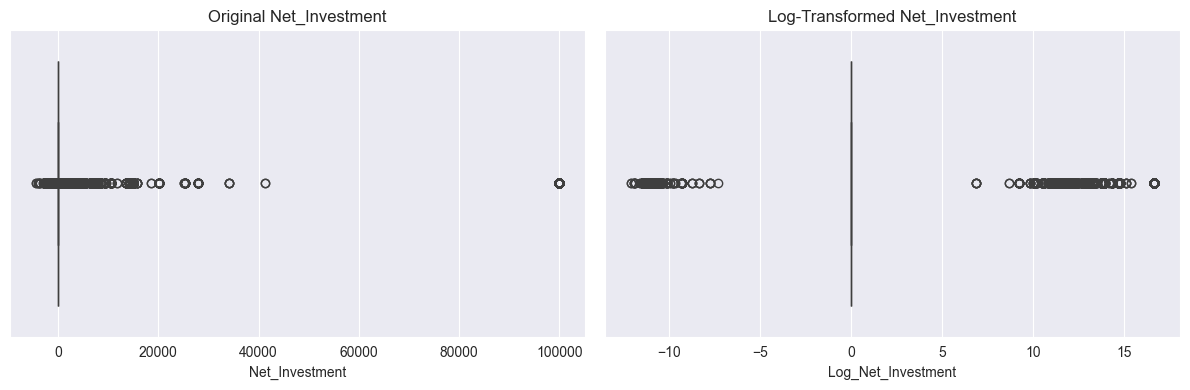

KeyError: 'Net_Investment'

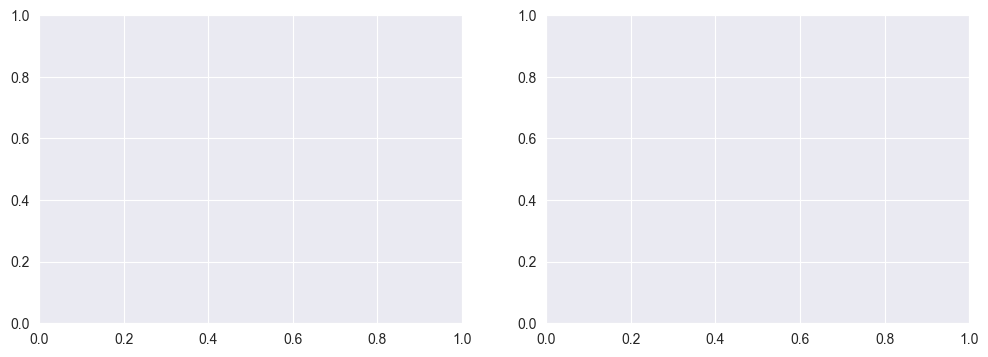

In [13]:
#Doing a log transformation while still distinguishing losses vs. gains.
processed_df['Net_Investment'] = processed_df['Investment_Gain'] - processed_df['Investment_Loss']
test['Net_Investment'] = test['Investment_Gain'] - test['Investment_Loss']

processed_df['Log_Net_Investment'] = np.sign(processed_df['Net_Investment']) * np.log2(abs(processed_df['Net_Investment']) + 1)
test['Log_Net_Investment'] = np.sign(test['Net_Investment']) * np.log2(abs(test['Net_Investment']) + 1)


# Side-by-side boxplots 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=processed_df['Net_Investment'], ax=axes[0])
axes[0].set_title('Original Net_Investment')
axes[0].set_xlabel('Net_Investment')

sns.boxplot(x=processed_df['Log_Net_Investment'], ax=axes[1])
axes[1].set_title('Log-Transformed Net_Investment')
axes[1].set_xlabel('Log_Net_Investment')

plt.tight_layout()
plt.show()

# Side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train['Net_Investment'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Distribution of Net_Investment')
axes[0].set_xlabel('Net_Investment')

sns.histplot(train['Log_Net_Investment'].dropna(), kde=True, ax=axes[1])
axes[1].set_title('Distribution of Log-Transformed Net_Investment')
axes[1].set_xlabel('Log_Net_Investment')

plt.tight_layout()
plt.show()


We applied a log transformation to Net_Investment to reduce skew and compress extreme outliers.
The resulting distribution is more symmetric, so we will keep it.


We applied a log transformation to column A to reduce skew and potentially improve its relationship with the target.
However, the correlation with Loan_Approval remained low, so we won't use it.

In [14]:
numeric_df = processed_df.select_dtypes(include="number")

# 2) Select all numeric columns (which now includes features + the target):
numeric_df = processed_df.select_dtypes(include="number")

# 3) Compute Pearson correlations against Loan_Approval:
corrs = numeric_df.corr()["Loan_Approval"].sort_values(ascending=False)
print(corrs)

Loan_Approval                        1.000000
Household_Role_Spouse                0.446926
Marital_Status_Married-civ-spouse    0.443064
Years_of_Education                   0.329367
Education_Level_higher               0.256696
                                       ...   
Education_Level_post_hs             -0.177284
customer_id                         -0.179697
Gender_Female                       -0.214018
Marital_Status_Never-married        -0.318068
Household_Role_Other                -0.446926
Name: Loan_Approval, Length: 67, dtype: float64


AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

Creating boolean masks to understand if the data is missed randomly or not.

In [ ]:
# 1. Create a boolean mask for missingness - job type
mask_Job_Type = train['Job_Type'].isna()            # True where missing
train['MissingFlag_Job_Type'] = mask_Job_Type.map({True: 'Missing', False: 'Present'})

# 2. Summary statistics for numeric vars
numeric_cols = ['Log_Net_Investment']
#numeric_cols = ['Age', 'Years_of_Education', 'Weekly_Work_Hours', 'Net_Investment', 'A', 'D', 'E']
print(train.groupby('MissingFlag_Job_Type')[numeric_cols].describe().unstack(1))

''' bring back after - just sick of the big graphs.
# 4. Frequencies for other categorical vars
cat_cols = ['Marital_Status', 'Household_Role', ]
for col in cat_cols:
    freq = pd.crosstab(train['MissingFlag_Job_Type'], train[col], normalize='index')
    print(f'\nRelative frequency of {col}:\n', freq)
    freq.plot.bar(stacked=True)
    plt.title(f'{col} by missingness')
    plt.ylabel('Proportion')
    plt.show()

'''

In [ ]:
# 1. Create a boolean mask for missingness with Investment_Gain to see if we can delete it to use YJ
mask_Investment_Gain = train['Investment_Gain'].isna()            # True where missing
train['MissingFlag_Investment_Gain'] = mask_Investment_Gain.map({True: 'Missing', False: 'Present'})

# 2. Summary statistics for numeric vars
numeric_cols = ['E']
#numeric_cols = ['Age', 'Years_of_Education', 'Weekly_Work_Hours', 'A', 'D', 'E']
print(train.groupby('MissingFlag_Investment_Gain')[numeric_cols].describe().unstack(1))


''' bring back after - just sick of the big graphs.

# 4. Frequencies for other categorical vars
cat_cols = ['Marital_Status', 'Household_Role', ]
for col in cat_cols:
    freq = pd.crosstab(train['MissingFlag_Investment_Gain'], train[col], normalize='index')
    print(f'\nRelative frequency of {col}:\n', freq)
    freq.plot.bar(stacked=True)
    plt.title(f'{col} by missingness')
    plt.ylabel('Proportion')
    plt.show()
'''

In [ ]:
# 1. Create a boolean mask for missingness with Ethnicity
mask_Ethnicity = train['Ethnicity'].isna()            # True where missing
train['MissingFlag_Ethnicity'] = mask_Ethnicity.map({True: 'Missing', False: 'Present'})

# 2. Summary statistics for numeric vars
numeric_cols = ['D']
#numeric_cols = ['Age', 'Years_of_Education', 'Weekly_Work_Hours', 'A', 'D', 'E']
print(train.groupby('MissingFlag_Ethnicity')[numeric_cols].describe().unstack(1))

'''
#bring back after - just sick of the big graphs.

# 4. Frequencies for other categorical vars
cat_cols = ['Marital_Status', 'Household_Role', 'Employment_Type', 'Job_Type', 'Gender', 'Country_of_Residence', 'Preferred_Communication_Method']
for col in cat_cols:
    freq = pd.crosstab(train['MissingFlag_Ethnicity'], train[col], normalize='index')
    print(f'\nRelative frequency of {col}:\n', freq)
    freq.plot.bar(stacked=True)
    plt.title(f'{col} by missingness')
    plt.ylabel('Proportion')
    plt.show()
'''

In [ ]:
# 1. Create a boolean mask for missingness with Ethnicity
mask_Ethnicity = train['Preferred_Communication_Method'].isna()            # True where missing
train['MissingFlag_Ethnicity'] = mask_Ethnicity.map({True: 'Missing', False: 'Present'})

# 2. Summary statistics for numeric vars
numeric_cols = ['Weekly_Work_Hours']
#numeric_cols = ['Age', 'Years_of_Education', 'Weekly_Work_Hours', 'A', 'D', 'E']
print(train.groupby('MissingFlag_Ethnicity')[numeric_cols].describe().unstack(1))

'''
#bring back after - just sick of the big graphs.

# 4. Frequencies for other categorical vars
cat_cols = ['Marital_Status', 'Household_Role', 'Employment_Type', 'Job_Type', 'Gender', 'Country_of_Residence', 'Preferred_Communication_Method']
for col in cat_cols:
    freq = pd.crosstab(train['MissingFlag_Ethnicity'], train[col], normalize='index')
    print(f'\nRelative frequency of {col}:\n', freq)
    freq.plot.bar(stacked=True)
    plt.title(f'{col} by missingness')
    plt.ylabel('Proportion')
    plt.show()
'''

In [ ]:
# 1. Create a boolean mask for Job type with Ethnicity
mask_Ethnicity = train['Job_Type'].isna()            # True where missing
train['MissingFlag_Ethnicity'] = mask_Ethnicity.map({True: 'Missing', False: 'Present'})

# 2. Summary statistics for numeric vars
numeric_cols = ['Weekly_Work_Hours']
#numeric_cols = ['Age', 'Years_of_Education', 'Weekly_Work_Hours', 'A', 'D', 'E']
print(train.groupby('MissingFlag_Ethnicity')[numeric_cols].describe().unstack(1))

'''
#bring back after - just sick of the big graphs.

# 4. Frequencies for other categorical vars
cat_cols = ['Marital_Status', 'Household_Role', 'Employment_Type', 'Job_Type', 'Gender', 'Country_of_Residence', 'Preferred_Communication_Method']
for col in cat_cols:
    freq = pd.crosstab(train['MissingFlag_Ethnicity'], train[col], normalize='index')
    print(f'\nRelative frequency of {col}:\n', freq)
    freq.plot.bar(stacked=True)
    plt.title(f'{col} by missingness')
    plt.ylabel('Proportion')
    plt.show()
'''

In [ ]:
# 1. Create a boolean mask for missingness with Ethnicity
mask_Ethnicity = train['Employment_Type'].isna()            # True where missing
train['MissingFlag_Ethnicity'] = mask_Ethnicity.map({True: 'Missing', False: 'Present'})

# 2. Summary statistics for numeric vars
numeric_cols = ['Weekly_Work_Hours']
#numeric_cols = ['Age', 'Years_of_Education', 'Weekly_Work_Hours', 'A', 'D', 'E']
print(train.groupby('MissingFlag_Ethnicity')[numeric_cols].describe().unstack(1))

'''
#bring back after - just sick of the big graphs.

# 4. Frequencies for other categorical vars
cat_cols = ['Marital_Status', 'Household_Role', 'Employment_Type', 'Job_Type', 'Gender', 'Country_of_Residence', 'Preferred_Communication_Method']
for col in cat_cols:
    freq = pd.crosstab(train['MissingFlag_Ethnicity'], train[col], normalize='index')
    print(f'\nRelative frequency of {col}:\n', freq)
    freq.plot.bar(stacked=True)
    plt.title(f'{col} by missingness')
    plt.ylabel('Proportion')
    plt.show()
'''

Based on our initial EDA (where we plotted boxplots and histograms in Part 1), we selected seven features—`net_investment_log`, `Weekly_Work_Hours`, `Years_of_Education`, `Age`, `A`, `D`, and `E`—for outlier removal. First, we computed and displayed the five-number summary (Min, Q1, Median, Q3, Max) for each to see which values lay far outside the interquartile range. For `net_investment_log`, we then calculated its mean and standard deviation and removed any rows whose values fell beyond ± 4 σ; this eliminates only about 800 observations (≈ 3 % of the data), preserving most valid high-net-worth cases. For the anonymous columns A and E, we used the IQR rule and deleted any rows outside \[Q1 − 1.5·IQR, Q3 + 1.5·IQR]. Feature D  which had a narrow IQR was trimmed for any value outside \[1, 9] (its 1.5·IQR boundaries) was removed. Since `Age` and `Years_of_Education` fell entirely within reasonable IQR bounds, we left them intact. Finally, because some applicants truly work long hours, we decided to remove (rather than cap) only those `Weekly_Work_Hours` values above the 99th percentile, ensuring that genuine 60–80-hour workweeks remain in the data while the most extreme outliers are excluded.

## 4. Model Training – Basic Models
_Start simple. Train Logistic Regression or KNN._

## 5. Model Training – Advanced Models
Choose 3 models from:
- Decision Tree
- Random Forest or AdaBoost
- Support Vector Machine
- Multi-Layer Perceptron (Neural Net)

_Include basic hyperparameter tuning or explain defaults._

## 6. Evaluation
- Build confusion matrix for at least one model
- Generate ROC curves (using K-Fold CV)
- Report AUC

**✏️ Answer in markdown:**
- Does any model overfit?
- Which model generalizes best?
- Final choice justification

## 7. Final Prediction on Test Set
_Predict probabilities (not binary labels!) and create submission file._

In [ ]:
# Example:
# final_model.predict_proba(test)[:, 1]  # ← probability of 'approved'
# submission = pd.DataFrame({
#     'customer_id': test['customer_id'],
#     'loan_approval': predictions
# })
# submission.to_csv('Submission_group_32.csv', index=False)

## 8. Appendix / Extra Notes
_Use this area for extra analysis, failed attempts, or ideas you explored._

We tried to handle the missing values with linear regression, but R^2 was 0.02, so we just impute with the median.
Trying:

In [94]:
######## TRY AGAIN AFTER ADDING AGE
'''
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

df = train  

# 1. Define features & split known vs missing
features = ['Weekly_Work_Hours', 'Years_of_Education', 'Age']
known   = df[df['Investment_Gain'].notnull() ].copy()
missing = df[df['Investment_Gain'].isnull()].copy()

X_known = known[features]
y_known = known['Investment_Gain']

# 2. Hold out 20% for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_known, y_known,
    test_size=0.2,
    random_state=42
)

# 3. Train on the 80%
lr = LinearRegression()
lr.fit(X_tr, y_tr)

# 4. Predict on the hold‐out and evaluate
y_pred = lr.predict(X_val)
print(f"R² on hold-out: {r2_score(y_val, y_pred):.3f}")
print(f"MAE on hold-out: {mean_absolute_error(y_val, y_pred):.3f}")

# 5. (Optional) Retrain on ALL known data and impute missings
lr_full = LinearRegression()
lr_full.fit(X_known, y_known)

X_missing = missing[features]
df.loc[df['Investment_Gain'].isnull(), 'Investment_Gain'] = lr_full.predict(X_missing)
'''


'\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import r2_score, mean_absolute_error\n\ndf = train  \n\n# 1. Define features & split known vs missing\nfeatures = [\'Weekly_Work_Hours\', \'Years_of_Education\', \'Age\']\nknown   = df[df[\'Investment_Gain\'].notnull() ].copy()\nmissing = df[df[\'Investment_Gain\'].isnull()].copy()\n\nX_known = known[features]\ny_known = known[\'Investment_Gain\']\n\n# 2. Hold out 20% for validation\nX_tr, X_val, y_tr, y_val = train_test_split(\n    X_known, y_known,\n    test_size=0.2,\n    random_state=42\n)\n\n# 3. Train on the 80%\nlr = LinearRegression()\nlr.fit(X_tr, y_tr)\n\n# 4. Predict on the hold‐out and evaluate\ny_pred = lr.predict(X_val)\nprint(f"R² on hold-out: {r2_score(y_val, y_pred):.3f}")\nprint(f"MAE on hold-out: {mean_absolute_error(y_val, y_pred):.3f}")\n\n# 5. (Optional) Retrain on ALL known data and impute missings\nlr_full = LinearRegression()\nlr_full